In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
from PIL import Image
import requests
from tqdm import tqdm

path = './data/'
p1= pd.read_csv(path+'users.csv')
p2= pd.read_csv(path+'books.csv')
p3= pd.read_csv(path+'train_ratings.csv')
p4= pd.read_csv(path+'sample_submission.csv')
p5= pd.read_csv(path+'test_ratings.csv') # test와 sample은 완벽하게 동일하다.
users  =p1.copy()
books  =p2.copy()
train  =p3.copy()
sample =p4.copy()
test   =p5.copy()

print('users shape: ', users.shape) 
print(users.columns)#유저id, 지역, 나이
print('books shape: ', books.shape)
print(books.columns)#isbn(책번호), 제목, 저자, 출판년도, 출판사, img주소, 언어, 범주, 요약, img경로
print('train shape: ', train.shape) 
print(train.columns)# 유저 id, 책isbn, 평점

users shape:  (68092, 3)
Index(['user_id', 'location', 'age'], dtype='object')
books shape:  (149570, 10)
Index(['isbn', 'book_title', 'book_author', 'year_of_publication', 'publisher',
       'img_url', 'language', 'category', 'summary', 'img_path'],
      dtype='object')
train shape:  (306795, 3)
Index(['user_id', 'isbn', 'rating'], dtype='object')


# 유저

In [2]:
print(users.nunique()) 
#유저 자체는 중복이 없고, 지역과 나이는 중복이 많다.
print(users.info())
# 지역에 0에 결측이 없다는 듯 말하지만 밑에 돌려보면 있다.
# 나이는 2만 정도 결측.
print(users.describe())
#id에 평균이니 뭐니는 쓸모 없다...만 최소가 0이 아니니 번호 내에 빈 값이 존재하긴 한다.
#평균 나이는 36. 이후에 그래프로 보면 더 나을 듯. 5살과 99살도 있으니 연령대는 다양.

user_id     68092
location    18368
age            91
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entries, 0 to 68091
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   68092 non-null  int64  
 1   location  68092 non-null  object 
 2   age       40259 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.6+ MB
None
             user_id           age
count   68092.000000  40259.000000
mean   139381.329539     36.069873
std     80523.969862     13.842571
min         8.000000      5.000000
25%     69008.750000     25.000000
50%    138845.500000     34.000000
75%    209388.250000     45.000000
max    278854.000000     99.000000


In [3]:
users.isna().sum() / len(users)
#지역은 위에서 말했듯 전처리가 필요하다.
#나이는 40퍼가 결측된다.

user_id     0.000000
location    0.000000
age         0.408756
dtype: float64

지역 나누기

In [8]:
#이제 지역을 전처리해보자. 사실 이건 이미 구현되어 있어서 직접 할 필요는 없을 것.

#'문자열'로 이뤄진 객체에 대해 .str을 통해 문자열 관련 함수를 쓸 수 있다.
#대표적으로 인덱싱, split, replace, extract, split 등. 웬만한 거 다 된다.
#정규표현식. []안에 드가면 일단 안속 범주에 해당하는 모든 것을 말한다.
# 그 안에서 ^는 not을 의미한다.
if 'location' in users.columns:
	tmp = users['location'].str.replace(r'[^0-9a-zA-Z:,]','') #즉 특수문자 제거!
	users.drop(['location'],axis=1,inplace=True) # 과감하게 버릴 건 버리자.

# def trisplit(x):
# 	a,b,c = x.split(',')
# 	return [a.strip(), b.strip(), c.strip()]
# a= tmp.apply(trisplit) #이건 왜 안 될까. 되게 하려면 어떻게 해야 할까
users['city']= tmp.apply(lambda x: x.split(',')[0].strip())
users['state']= tmp.apply(lambda x: x.split(',')[1].strip())
users['country']= tmp.apply(lambda x: x.split(',')[2].strip())
#시,주,국가로 나누는 과정

users = users.replace('na', np.nan).replace('', np.nan).replace('nan', np.nan)
#na나 빈칸을 결측으로 간주하기 위한 전처리
print(users)


/tmp/ipykernel_2711/503263225.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  tmp = users['location'].str.replace(r'[^0-9a-zA-Z:,]','') #즉 특수문자 제거!


       user_id   age         city            state country
0            8   NaN      timmins          ontario  canada
1        11400  49.0       ottawa          ontario  canada
2        11676   NaN          NaN              NaN     NaN
3        67544  30.0      toronto          ontario  canada
4        85526  36.0     victoria  britishcolumbia  canada
...        ...   ...          ...              ...     ...
68087   278376  54.0     danville     pennsylvania     usa
68088   278621  74.0     victoria         delaware  canada
68089   278636   NaN    irvington          alabama     usa
68090   278659  33.0    vancouver       washington     usa
68091   278713  63.0  albuquerque        newmexico     usa

[68092 rows x 5 columns]


In [5]:
users.isna().sum()/len(users)
#상대적으로 지역은 결측치가 적다. 중복되게 count됐으니 더 적을 것이다.
#의미가 있을 경우, 지역을 유저 속성으로 활용할 수 있다.

user_id    0.000000
age        0.408756
city       0.001792
state      0.047788
country    0.031193
dtype: float64

스페셜 미션 내용. 지역 결측치 메꾸기

In [9]:
modify = users[(users['country'].isna())&(users['city'].notnull())]['city'].values
#나라는 없는 주제에 도시는 있는 놈들의 도시의 값들을 저장함.

#value_counts는 해당 series의 고유한 값들을 인덱스로 삼고 갯수를 값으로 가지는 sereis를 반환한다.
location_list = []
for i in modify:
	try:
		#value_counts는 각 고유한 값들의 분포를 나타내준다.
		tmp = users[users['city'].str.contains(i) & users['country'].notnull()]
		city_tmp = tmp['city'].value_counts().index[0]
		state_tmp = tmp['state'].value_counts().index[0]
		country_tmp = tmp['country'].value_counts().index[0]
		location_list.append((city_tmp, state_tmp, country_tmp))
		#
	except: pass

In [10]:
#loc은 인덱스 단위로 행 접근, iloc은 행번호 단위로 행 접근. 
#인덱스는 우리가 지정해주는 값이다. 그래서 정수가 아니어도 됨.
#행번호는 말그대로 행의 순서대로 부여되는 번호이다.

for location in location_list:
    users.loc[users[users['city']==location[0]].index,'state'] = location[1]
    users.loc[users[users['city']==location[0]].index,'country'] = location[2]

In [11]:
users.isna().sum()/len(users)
#도시를 기준으로 값을 메꿨다. 주는 많이 줄지 않았지만 국가는 확실하게 결측이 줄어든 모습이다.

user_id    0.000000
age        0.408756
city       0.001792
state      0.016346
country    0.003510
dtype: float64

사람이 적은 국가 others로 퉁치기

In [12]:
# users[users['country'].value_counts() < 10]

#특정 소수만 뽑아내는 방법. 일단 valuecount데이터 프레임 만들기
country_dict = users['country'].value_counts().to_dict()
country_count = pd.DataFrame(country_dict.items(), columns=['country', 'count'])

tmp = country_count[country_count['count'] <100]['country'].values # 이제 5개 이하의 국가들 알아냈다.
user = users.copy() #혹시 몰라서 복사해서 사용함.
user.loc[users[users['country'].isin(tmp)].index, 'country'] = 'others'

user.loc[user[user['country'] == 'others'].index, 'state'] = 'others'
# user.loc[user[user['country'] == 'others'].index, 'city'] = 'others'
user['city'].where(user['country'] != 'others', 'others', inplace=True)

#############################################################
users = user.copy()#이 코드로 내 전처리가 적용된다.
############################################################


이렇게 해도 남는 결측치나 이상한 국가, 혹은 도시를 통해 유추할 수 있음에도 제대로 기록되지 않는 국가, 같은 국가인데 표기가 달리 된 국가들을 일일히 검색해서 손으로 메꿔줌.

나이 분포 확인

<AxesSubplot: xlabel='age'>

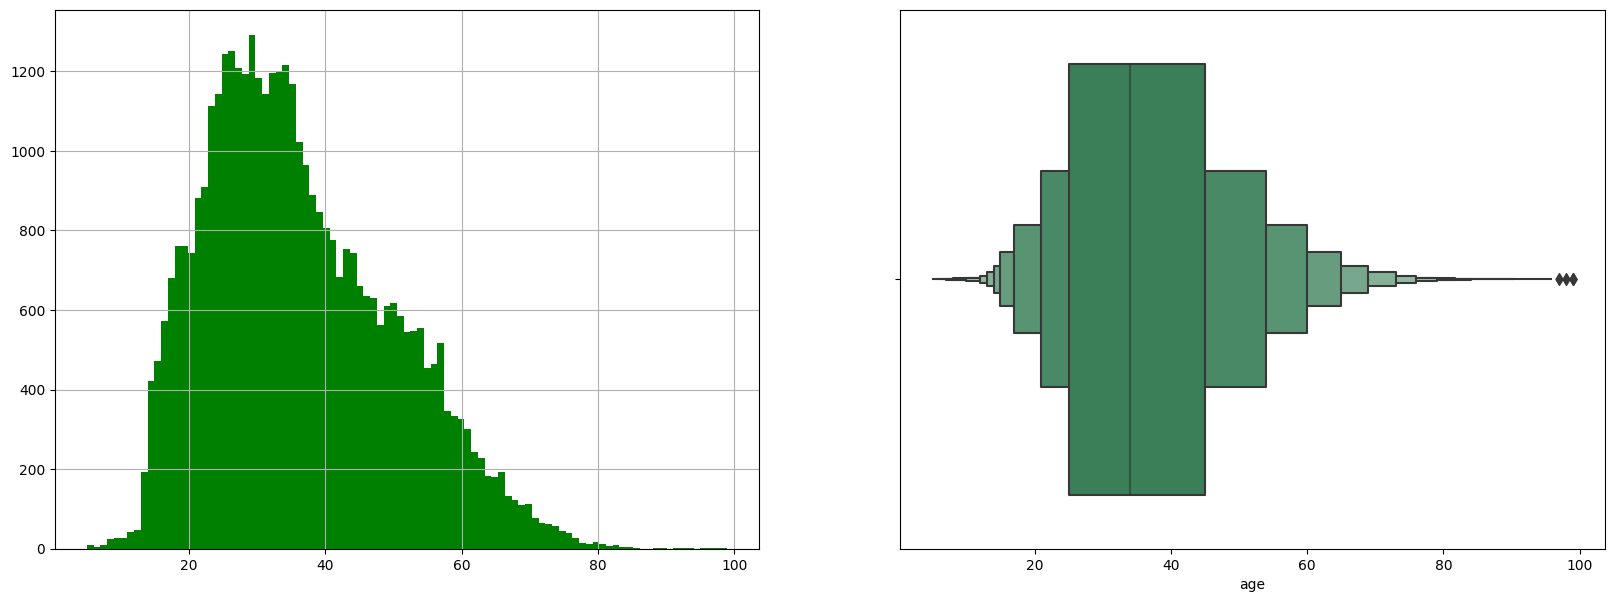

In [13]:
fig, ax = plt.subplots(1,2,figsize=(20,7))

#bins는 데이터를 smoothing할 비율인 듯.
users['age'].hist(bins=95, color='green', ax=ax[0])
sns.boxenplot(data=users, x='age', color='seagreen',ax=ax[1])
#박스플롯

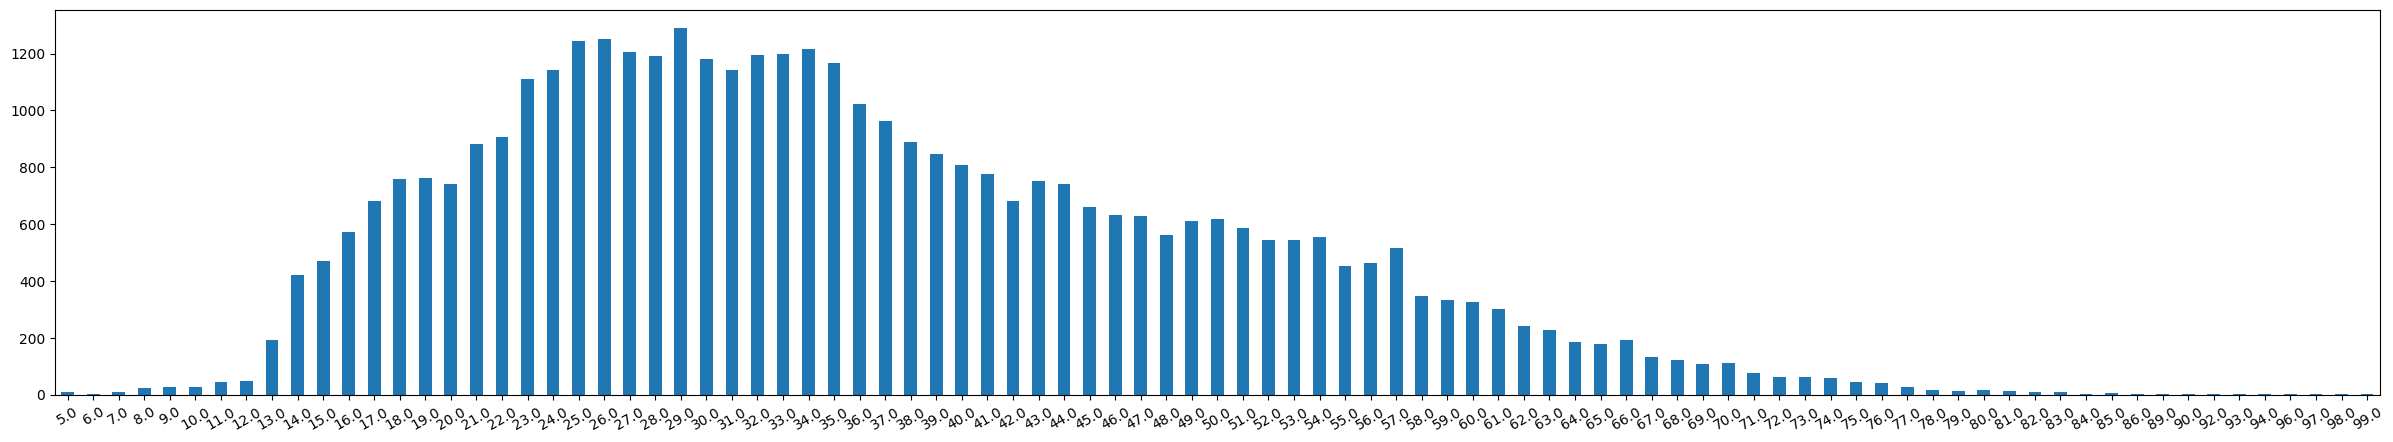

In [14]:
plt.figure(figsize=(30,5))
users['age'].value_counts().sort_index().plot(kind='bar')
plt.xticks(rotation=30)
plt.show()
#2,30대로 갈수록 많아지는 완만한 형태

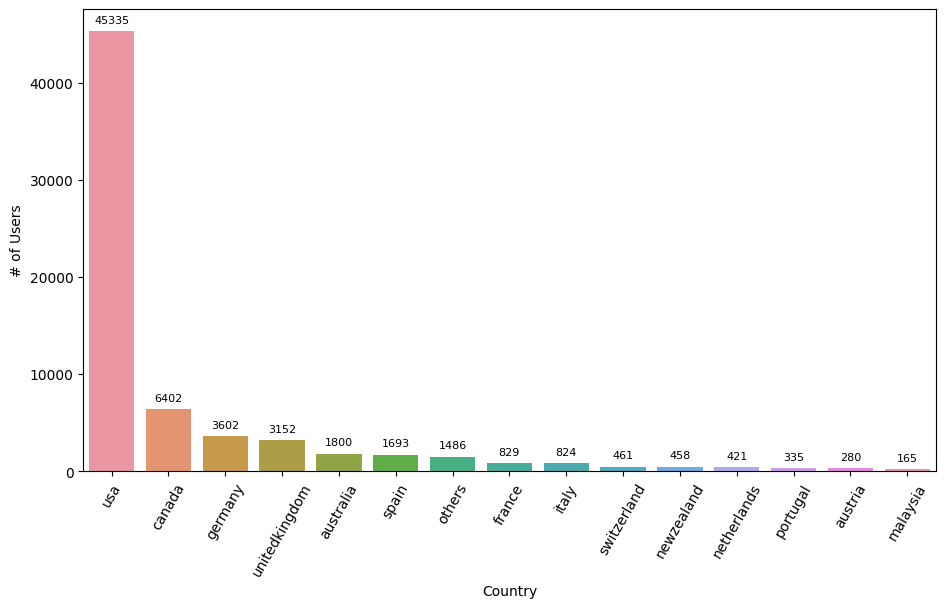

In [15]:
my_dict=(users['country'].value_counts()).to_dict() #간단하게 딕트로 만들기.
count= pd.DataFrame(list(my_dict.items()),columns = ['country','count'])
f = count.sort_values(by=['count'], ascending = False)
f = f.head(15) #많은 국가 15개만
# f.drop(7,inplace=True)
fig=plt.figure(figsize=(11,6))
ax = sns.barplot(y = 'count',x= 'country' , data = f)
ax.set_xticklabels(ax.get_xticklabels(), rotation=60,horizontalalignment='center')
for bar in ax.patches: 
    ax.annotate(format(bar.get_height(), '.0f'),  
                   (bar.get_x() + bar.get_width() / 2,  
                    bar.get_height()), ha='center', va='center', 
                   size=8, xytext=(0,8), 
                   textcoords='offset points') 

plt.xlabel("Country", size=10)
plt.ylabel("# of Users", size=10)
plt.show()
# 국가는 언어와 연관된다. 
# 스페인까지만 제대로 고려해도 될 듯하다.

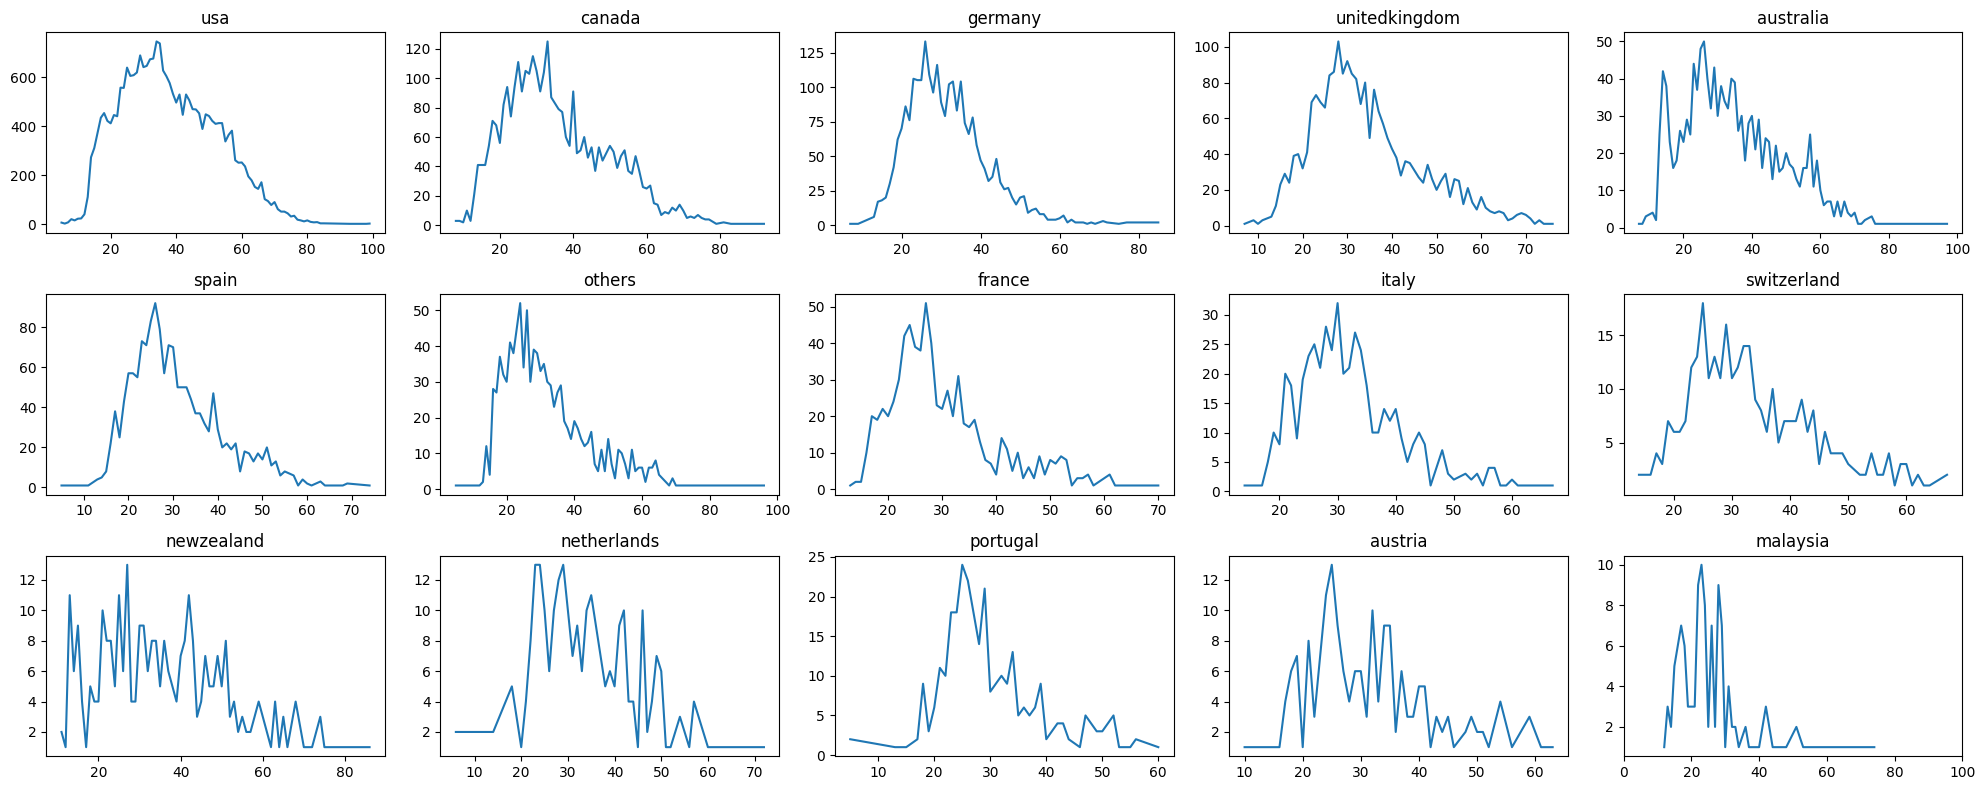

In [16]:
fig, ax = plt.subplots(3,5,figsize=(20,8))
for country, ax_ in zip(f['country'], ax.flatten()):
    users[(users['country']==country)]['age'].value_counts().sort_index().plot(ax=ax_, title=country)
plt.xlim(0,100)
plt.tight_layout()
plt.show()
#스페인 정도 급 되지 않는 이상 보이는 그래프를 믿을 필요 없다고 생각한다. 

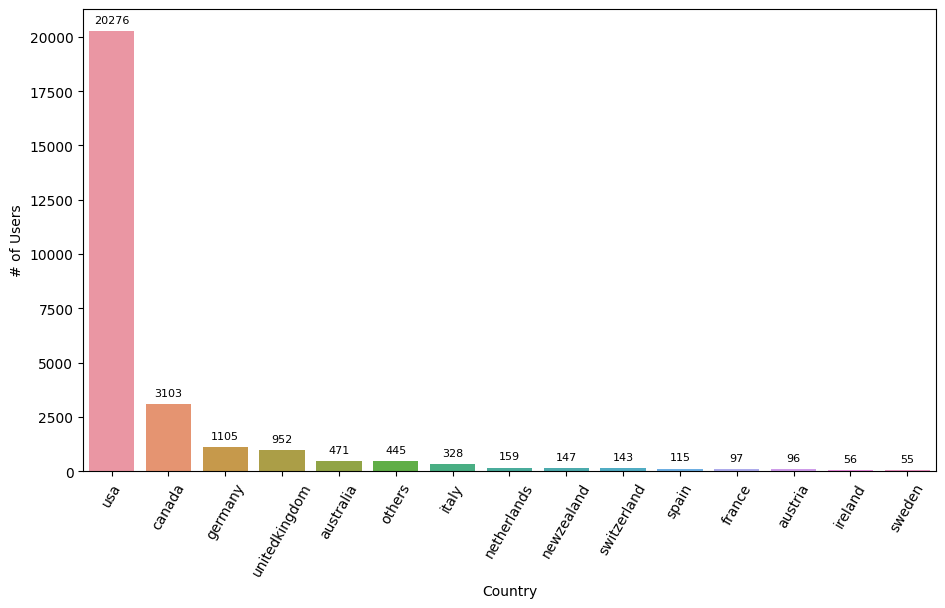

In [17]:
#국가별 결측치에 대한 시각화
my_dict=(users[users['age'].isna()]['country'].value_counts()).to_dict()
count= pd.DataFrame(list(my_dict.items()),columns = ['country','count'])
f = count.sort_values(by=['count'], ascending = False)
f = f.head(15)
fig=plt.figure(figsize=(11,6))
ax = sns.barplot(y = 'count',x= 'country' , data = f)
ax.set_xticklabels(ax.get_xticklabels(), rotation=60,horizontalalignment='center')
for bar in ax.patches: 
    ax.annotate(format(bar.get_height(), '.0f'),  
                   (bar.get_x() + bar.get_width() / 2,  
                    bar.get_height()), ha='center', va='center', 
                   size=8, xytext=(0,8), 
                   textcoords='offset points') 

plt.xlabel("Country", size=10)
plt.ylabel("# of Users", size=10)
plt.show()
#결측치는 국가별로 고르게 나타난다.

결측치를 채울 방법. 나온 분포를 그대로 확률 분포로 써서 random.choice로 채울 수 있지 않을까? 나이대의 이상치가 그다지 없어서 완전 평균을 사용해도 문제는 없을 것 같다. 
확인해볼 사항. 나이대별로, 혹은 국가 별로 다른 평점을 매기고 있지는 않은가?

In [22]:
age_na = users[users['age'].notna()]['age'].tolist()
users['age'].where(users['age'].notna(), np.random.choice(age_na), inplace=True)
#실패한 방법. 원하는 바를 이루려면 for문이나 돌리는 게 편하다

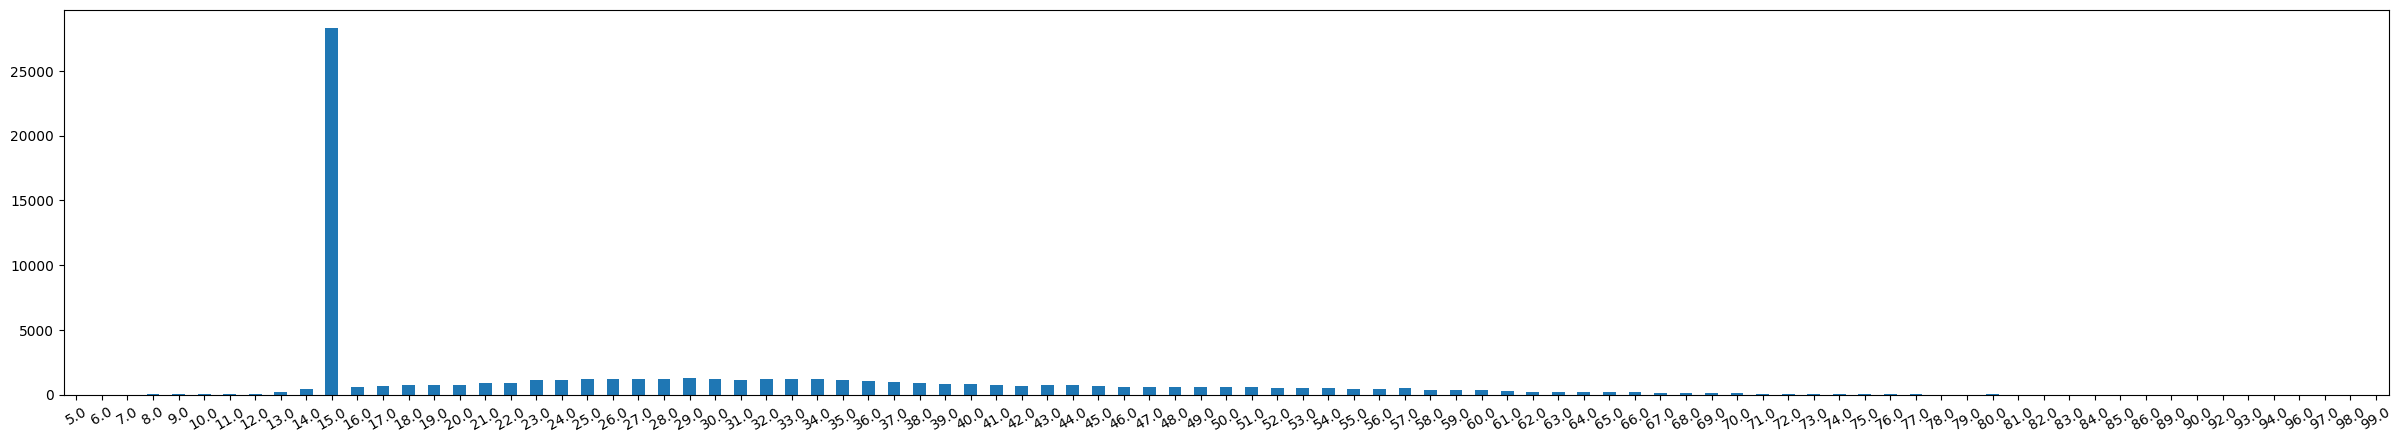

In [23]:
#제대로 메꿔지는지 확인
plt.figure(figsize=(30,5))
users['age'].value_counts().sort_index().plot(kind='bar', color='green')
plt.xticks(rotation=30)
plt.show()
# 한 값으로만 적용된다.

In [72]:
users  =p1
#실수 메꾸기

In [ ]:
age_na = users[users['age'].notna()]['age'].tolist()
for i, j in tqdm(enumerate(users['age'])):
	if np.isnan(j):
		users['age'].iloc[i] = np.random.choice(age_na)

<BarContainer object of 91 artists>

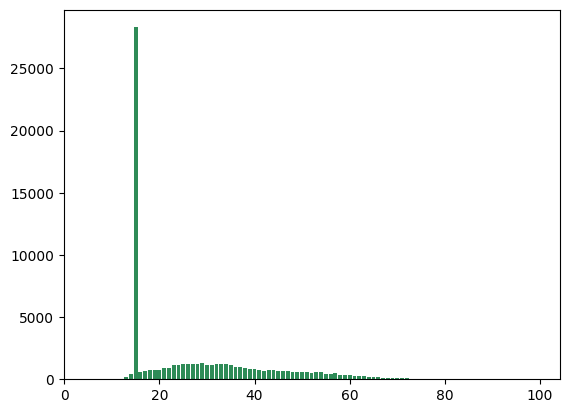

In [63]:
fig, ax = plt.subplots(1,1)

age = users['age'].value_counts().to_dict()
ax.bar(age.keys(), age.values(), color='seagreen')


간단하게나마 나이 결측치 메꾸기. 그러나 결측치라는 정보 자체를 훼손하고 있을 가능성도 있음.\
조금 더 면밀한 관찰이 필요함

In [76]:
users  =p1
#돌다리 두드리기

27833

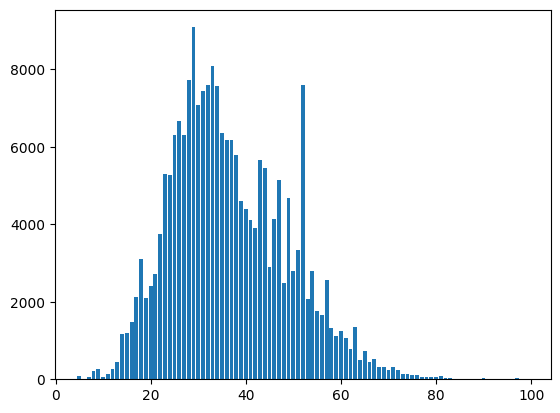

In [82]:
train = train.merge(users).merge(books)

tmp = train['age'].value_counts().to_dict()
fig, ax = plt.subplots(1,1)
ax.bar(tmp.keys(), tmp.values())
len(users[users['age'].isna()]['age'])
#학습셋에서의 나이치. 나이 결측치 보완을 위해 나이 결측을 냅두고 진행중이다.

In [83]:
def change_age(x):
	if x < 10: return 0
	elif 10 <= x < 20: return 1
	elif 20 <= x < 30: return 2
	elif 30 <= x < 40: return 3
	elif 40 <= x < 50: return 4
	elif 50 <= x < 60: return 5
	elif 60 <= x < 70: return 6
	elif 70 <= x <= 100: return 7
	else: return np.nan

train['age'] = train['age'].map(change_age)
train['age']

0         NaN
1         3.0
2         NaN
3         NaN
4         NaN
         ... 
306790    5.0
306791    7.0
306792    NaN
306793    3.0
306794    6.0
Name: age, Length: 306795, dtype: float64

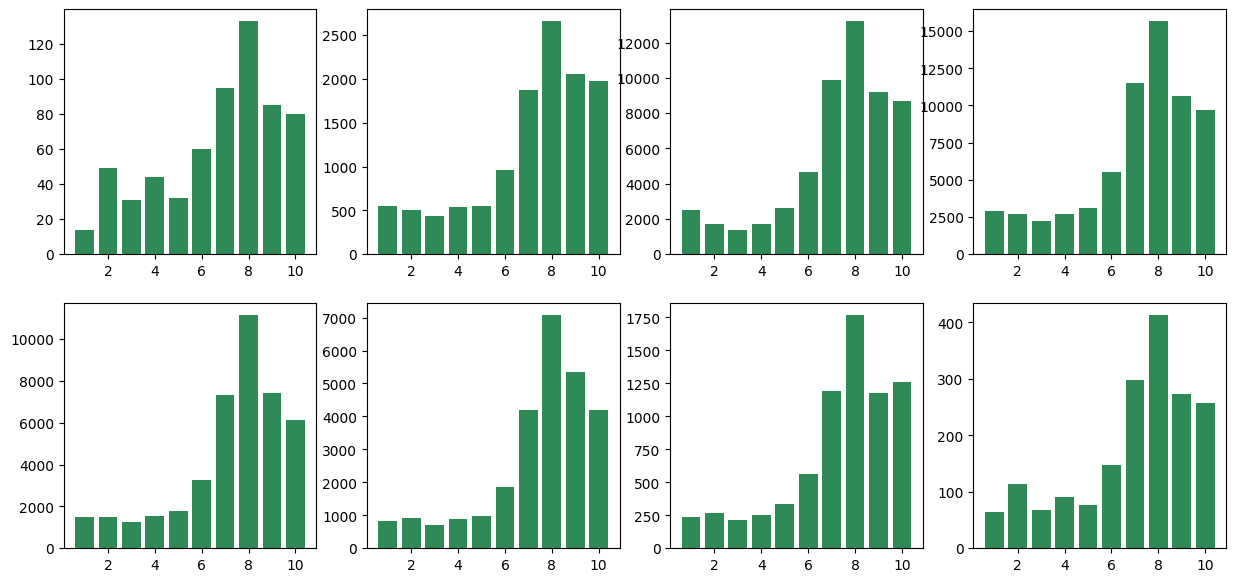

In [84]:
#나이대 별 평점 분포
fig, ax = plt.subplots(2,4, figsize=(15,7))
ax = ax.flatten()

for i in range(8):
	tmp = train[train['age'] == i]
	tmp = tmp['rating'].value_counts().to_dict()
	ax[i].bar(tmp.keys(), tmp.values(), color='seagreen')

plt.show()
#전체적인 분포는 비슷해보인다. 

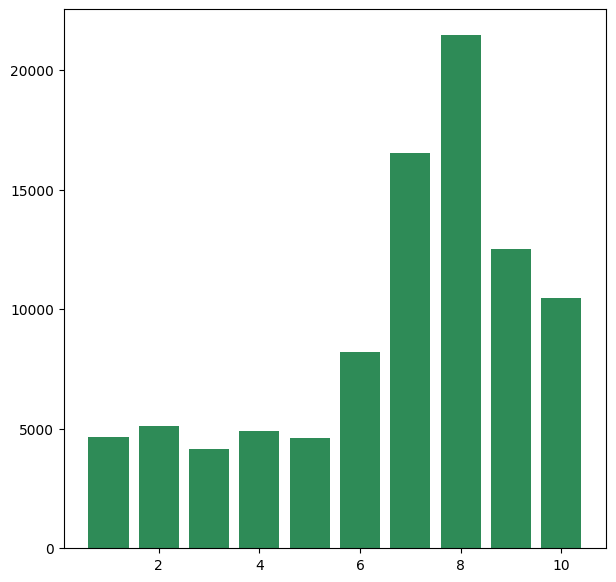

In [85]:
#이놈들이 결측된 나이들의 평점 분포이다. 
fig, ax = plt.subplots(1,1, figsize=(7,7))
ax = ax

for i in range(1):
	tmp = train[train['age'].isna()]
	tmp = tmp['rating'].value_counts().to_dict()
	ax.bar(tmp.keys(), tmp.values(), color='seagreen')

plt.show()

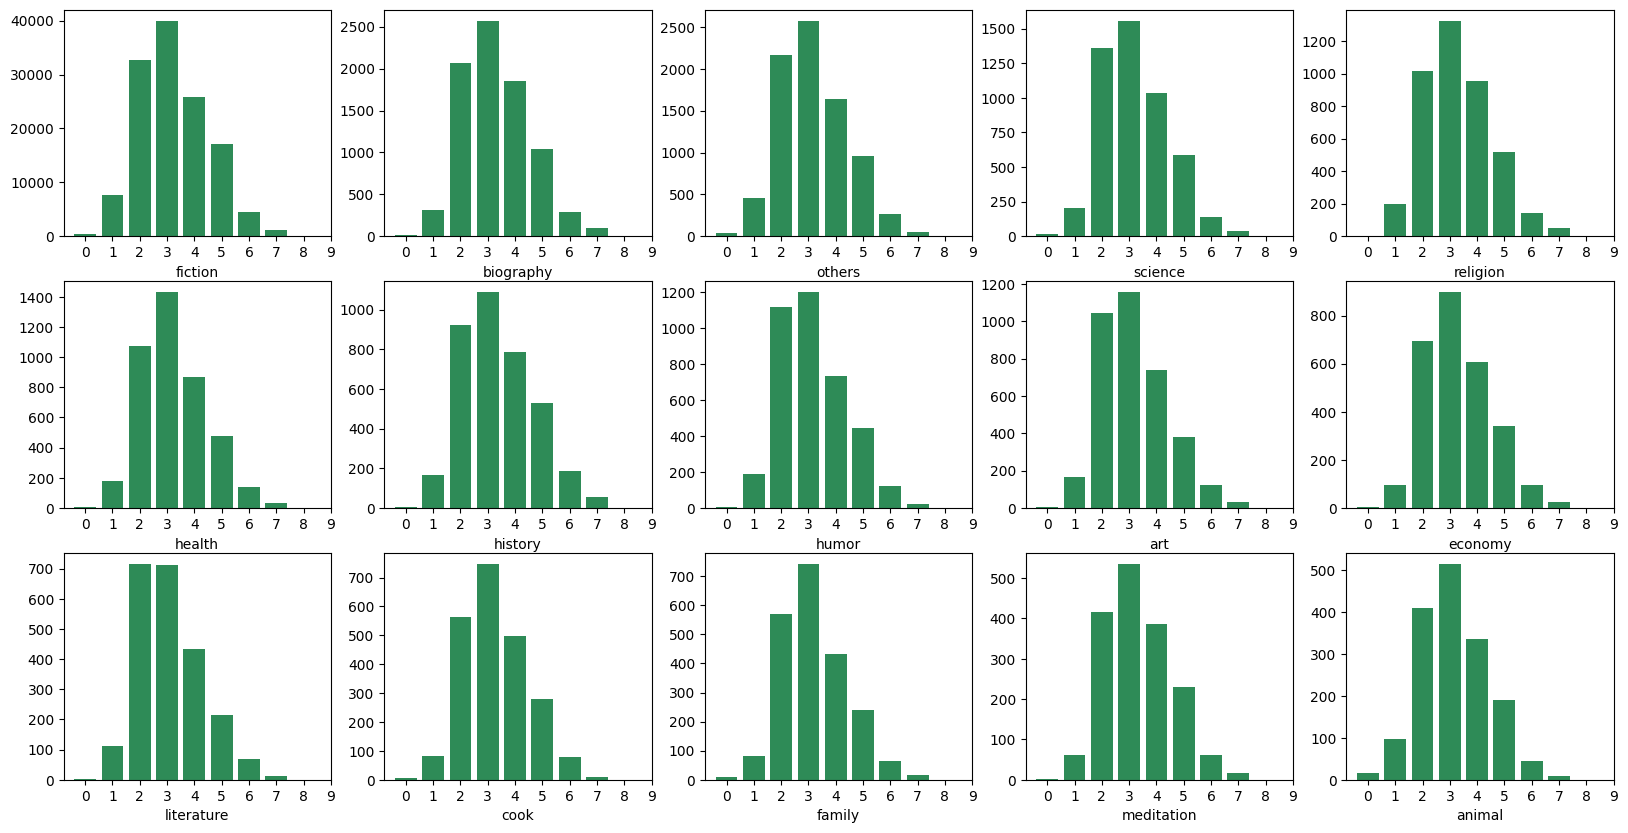

In [86]:
##########################################################
#주의! 이 코드는 아래 책 데이터 범주 처리 이후에 만들어진 코드.
#그렇기에 아래를 먼저 실행시키고 와야 제대로 볼 수 있음
#범주 별로 나이 분포 확인
tmp = pd.DataFrame(train['high_category'].value_counts().to_dict().items(), columns=['category', 'count'])
categor = tmp[:15]

fig, ax = plt.subplots(3,5, figsize=(20,10))
ax = ax.flatten()
for i in range(15):
	tmp = train[train['high_category'] == categor.iloc[i][0]]
	tmp = tmp['age'].value_counts().to_dict()
	ax[i].bar(tmp.keys(), tmp.values(), color='seagreen')
	ax[i].set_xlabel(f'{categor.iloc[i][0]}')
	ax[i].set_xticks(np.arange(10))

plt.show()

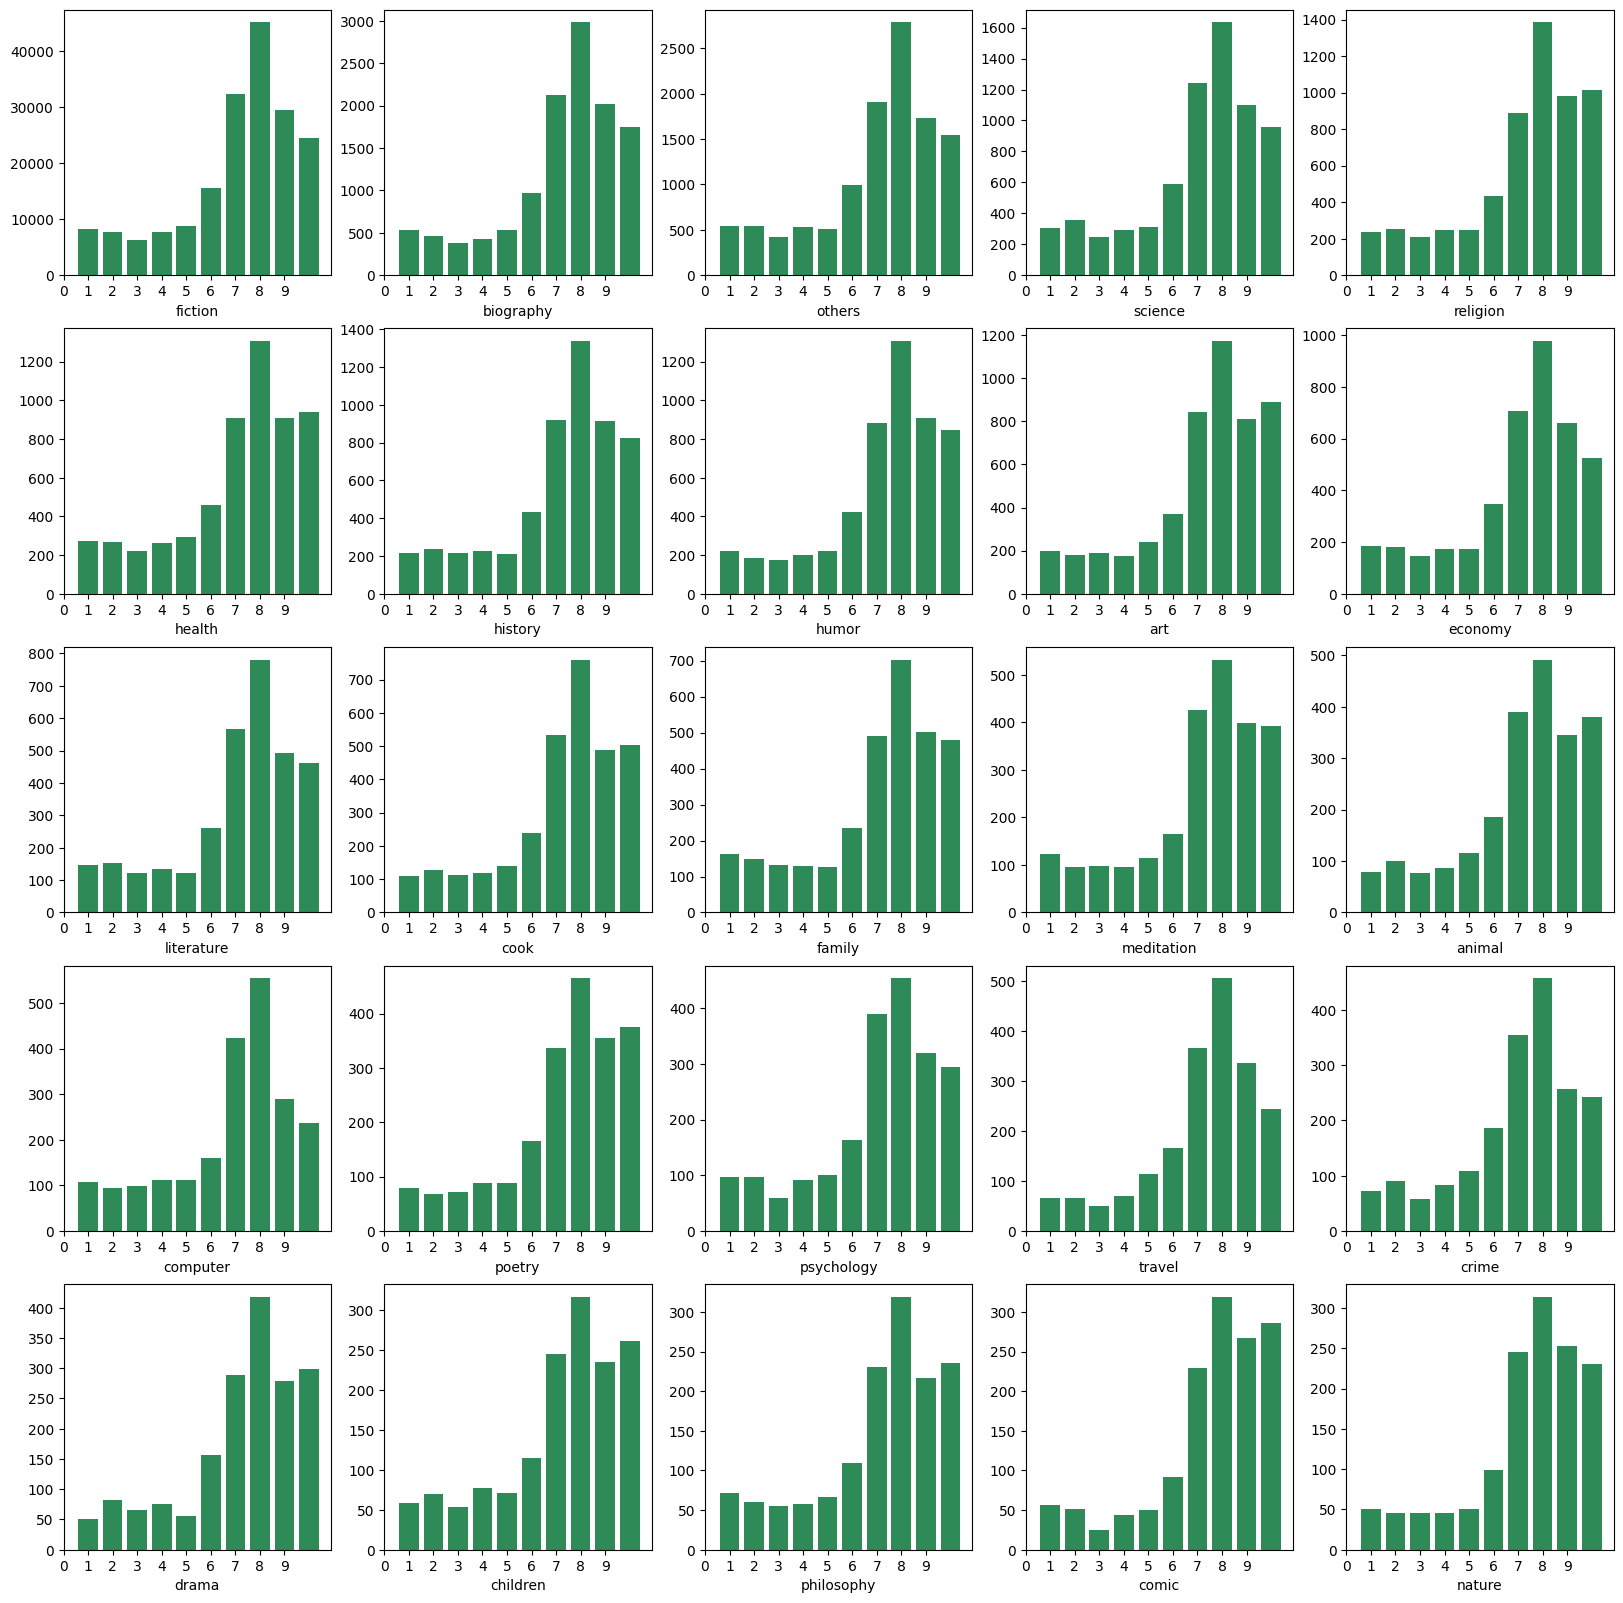

In [87]:
#밤주 별로 평점 분포 확인
tmp = pd.DataFrame(train['high_category'].value_counts().to_dict().items(), columns=['category', 'count'])
categor = tmp[:25]

fig, ax = plt.subplots(5,5, figsize=(20,20))
ax = ax.flatten()
for i in range(25):
	tmp = train[train['high_category'] == categor.iloc[i][0]]
	tmp = tmp['rating'].value_counts().to_dict()
	ax[i].bar(tmp.keys(), tmp.values(), color='seagreen')
	ax[i].set_xlabel(f'{categor.iloc[i][0]}')
	ax[i].set_xticks(np.arange(10))

plt.show()

지역에 대한 추가 전처리. 지역을 나라만 남기고 종교권, 문화권으로 묶어보자는 제의가 들어옴.

In [91]:
#이를 위해 위 과정을 거쳐 저장해둔 csv파일을 불러옴.
users = pd.read_csv('/opt/ml/input/code/users_fillna.csv')
users

,user_id,age,country
0,8,24.0,canada
1,11400,49.0,canada
2,11676,46.0,usa
3,67544,30.0,canada
4,85526,36.0,canada
...,...,...,...
68087,278376,54.0,usa
68088,278621,74.0,canada
68089,278636,12.0,usa
68090,278659,33.0,canada


전처리 방법은 아래 책 범주 처리 방법을 참조. 일일히 손으로 다 도시들을 검색해가면서 나라 결측을 메꿈.

In [92]:
#종교권 묶기
users['religion'] = users['country'].copy()

In [93]:
christian = ['usa', 'australia', 'newzealand', 'ireland', 'england', 'canada', 'norway', 'iceland', 'pinland', 'southafrica', 'israel']
catholic = ['portugal', 'brazil', 'germany', 'austria', 'france', 'italy', 'netherlands', 'poland', 'spain',\
			'argentina', 'romania', 'switzerland', 'belgium', 'sweden', 'greece', 'denmark', \
			'czechrepublic', 'venezuela', 'costarica', 'hungary', 'luxembourg', 'slovenia',\
			'uruguay', 'mexico', 'phillipines', 'finland']
islam = ['iran', 'kuwait', 'malaysia', 'pakistan', 'turkey', 'indonesia', 'egypt']
buddism = ['hongkong', 'china', 'japan', 'southkorea', 'singapore']
hindu = ['india']
#책 범주 처리에서 유래된 k동건 클러스터링..  

In [94]:
users['religion'].where(users['religion'].isin(christian) == False, 'christian', inplace=True)
users['religion'].where(users['religion'].isin(catholic) == False, 'christian', inplace=True)
users['religion'].where(users['religion'].isin(islam) == False, 'islam', inplace=True)
users['religion'].where(users['religion'].isin(buddism) == False, 'buddism', inplace=True)
users['religion'].where(users['religion'].isin(hindu) == False, 'hindu', inplace=True)

In [95]:
users['religion'].value_counts()

christian        63742
unitedkingdom     3611
buddism            266
others             223
islam              215
hindu               35
Name: religion, dtype: int64

In [96]:
#문화권 묶기
users['continent'] = users['country'].copy()

In [97]:
n_america = ['usa', 'canada']
s_america = ['brazil','argentina','czechrepublic', 'venezuela', 'costarica', 'uruguay', 'mexico']
europe    = ['england', 'norway', 'iceland', 'pinland', 'portugal',  'germany', 'austria', 'france', 'italy', 'netherlands', 'poland', 'spain',\
			'romania', 'switzerland', 'belgium', 'sweden', 'greece', 'denmark', 'hungary', 'luxembourg', 'slovenia', 'finland']
islam     = ['iran', 'kuwait', 'malaysia', 'pakistan', 'turkey', 'egypt', 'israel']
africa    = ['southafrica']
e_asia    = ['hongkong', 'china', 'japan', 'southkorea']
en_asia   = ['phillipines', 'indonesia', 'singapore']
inida     = ['india']
ause      = ['australia', 'newzealand']

In [98]:
users['continent'].where(users['continent'].isin(n_america) == False, 'n_america', inplace=True)
users['continent'].where(users['continent'].isin(s_america) == False, 's_america', inplace=True)
users['continent'].where(users['continent'].isin(europe) == False, 'europe', inplace=True)
users['continent'].where(users['continent'].isin(islam) == False, 'islam', inplace=True)
users['continent'].where(users['continent'].isin(inida) == False, 'inida', inplace=True)
users['continent'].where(users['continent'].isin(africa) == False, 'africa', inplace=True)
users['continent'].where(users['continent'].isin(e_asia) == False, 'e_asia', inplace=True)
users['continent'].where(users['continent'].isin(en_asia) == False, 'en_asia', inplace=True)
users['continent'].where(users['continent'].isin(ause) == False, 'ause', inplace=True)

In [99]:
users['continent'].value_counts()

n_america        52378
europe            8704
unitedkingdom     3611
ause              2223
s_america          281
islam              226
others             223
en_asia            194
e_asia             143
africa              37
ireland             37
inida               35
Name: continent, dtype: int64

# 책

In [25]:
print(books.shape)
books.columns

(149570, 10)


Index(['isbn', 'book_title', 'book_author', 'year_of_publication', 'publisher',
       'img_url', 'language', 'category', 'summary', 'img_path'],
      dtype='object')

In [26]:
print(books.nunique())
#isbn, img는 죄다 고유하다. 
print(books.isna().sum())
#언어, 범주, 요약은 많이 결측돼있다. 이건 전처리로 함부로 채울 수 없을 것 같다.
#언어와 요약은 수가 같은 것으로 보아 같이 결측되는 듯. 확인해보자

isbn                   149570
book_title             135436
book_author             62059
year_of_publication        95
publisher               11571
img_url                149570
language                   26
category                 4292
summary                 79872
img_path               149570
dtype: int64
isbn                       0
book_title                 0
book_author                0
year_of_publication        0
publisher                  0
img_url                    0
language               67227
category               68851
summary                67227
img_path                   0
dtype: int64


In [27]:
books[books['language'].isna() & books['summary'].notna()]
#완벽히 결측은 일치한다.

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path


In [28]:
books[books['category'].isna() & books['summary'].isna()].shape
#요약이나 언어가 없는 데이터는 전부 범주도 없다.
#요약이 있으면서 범주 없는 데이터가 차이만큼 존재한다는 것이기도 하다.


(67227, 10)

출판사 건드리기

In [29]:
books[books['publisher']=="Penguin Books"].head()
#펭귄 책 출판사는 isbn이 014로 시작한다.

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path
68,0140067477,The Tao of Pooh,Benjamin Hoff,1983.0,Penguin Books,http://images.amazon.com/images/P/0140067477.0...,en,['Humor'],An expert in Chinese philosophy explains facet...,images/0140067477.01.THUMBZZZ.jpg
119,0143034359,Thursday Next in the Well Of Lost Plots (Thurs...,Fforde Jasper,2004.0,Penguin Books,http://images.amazon.com/images/P/0143034359.0...,en,['Fiction'],Exhausted by her stint as Miss Havisham&#39;s ...,images/0143034359.01.THUMBZZZ.jpg
157,0140250964,Snow Angels,Stewart O'Nan,1995.0,Penguin Books,http://images.amazon.com/images/P/0140250964.0...,en,['Fiction'],Weaves together two stories in the account of ...,images/0140250964.01.THUMBZZZ.jpg
196,0140272100,Vanished,Mary McGarry Morris,1997.0,Penguin Books,http://images.amazon.com/images/P/0140272100.0...,en,['Fiction'],Aubrey Wallace is the kind of man no one notices.,images/0140272100.01.THUMBZZZ.jpg
298,014028009X,Bridget Jones's Diary,Helen Fielding,1999.0,Penguin Books,http://images.amazon.com/images/P/014028009X.0...,en,['Fiction'],This witty national bestseller is now availabl...,images/014028009X.01.THUMBZZZ.jpg


In [30]:
books[books['isbn'].str.startswith('014')].sample(5)
#그래서 014로 isbn 찍어보니.. 출판사 이름이 조금씩 다르게 표기되어 있다. 통일시킬 수 있다.

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path
50072,0140443002,The Nun (Penguin Classics),Denis Diderot,1977.0,Penguin Books,http://images.amazon.com/images/P/0140443002.0...,en,['Fiction'],"Denis Diderot (1713-84), editor of the Encyclo...",images/0140443002.01.THUMBZZZ.jpg
11552,0142000396,The Last Manly Man (Robin Hudson Mysteries (Pa...,Sparkle Hayter,2001.0,Penguin Books,http://images.amazon.com/images/P/0142000396.0...,en,['Fiction'],A series of random encounters and one dead man...,images/0142000396.01.THUMBZZZ.jpg
97011,0140552812,Spot Goes to the Beach (Picture Puffins),Eric Hill,1995.0,Penguin Putnam Books for Young Readers,http://images.amazon.com/images/P/0140552812.0...,en,['Beaches'],Join Spot for a day of sun and fun! When Spot ...,images/0140552812.01.THUMBZZZ.jpg
88992,0140276424,Five Against One: The Pearl Jam Story,Kim Neely,1998.0,Penguin Books,http://images.amazon.com/images/P/0140276424.0...,NaN,NaN,NaN,images/0140276424.01.THUMBZZZ.jpg
49611,0140187499,The Short Reign of Pippin IV: A Fabrication (T...,John Steinbeck,1994.0,Penguin Books,http://images.amazon.com/images/P/0140187499.0...,en,['Literary Collections'],Being drafted as ruler of France has life-chan...,images/0140187499.01.THUMBZZZ.jpg


In [31]:
print((books['publisher'].nunique()))
#통일시키기 전의 출판사 갯수

11571


In [32]:
#출판사
publisher_dict=(books['publisher'].value_counts()).to_dict()
publisher_count_df= pd.DataFrame(list(publisher_dict.items()),columns = ['publisher','count'])
modify_list = publisher_count_df[publisher_count_df['count']>1].publisher.values
#1개만 낸 출판사는 이름이 잘못됐을 것이라 가정.
print(modify_list.shape)
for publisher in modify_list:
    try:
        number = books[books['publisher']==publisher]['isbn'].apply(lambda x: x[:4]).value_counts().index[0]
		#출판사의 isbn 앞자리
        right_publisher = books[books['isbn'].apply(lambda x: x[:4])==number]['publisher'].value_counts().index[0]
		#그 출판사의 이름
        books.loc[books[books['isbn'].apply(lambda x: x[:4])==number].index,'publisher'] = right_publisher
    except: 
        pass

(5276,)


카테고리 건드리기

In [33]:
#일단 보기 좋게 글자 정리
#re.sub(정규표현식, 치환 문자, 대상 문자열) replace해준다.
#\W는 알파벳, 숫자, _가 아닌 모든 문자, 즉 특수문자! +는 반복이 있을 수 있다는 것을 뜻한다.
books.loc[books[books['category'].notnull()].index, 'category'] = \
	books[books['category'].notnull()]['category'].apply(lambda x: re.sub('[\W_]+',' ',x).strip())
books['category'] = books['category'].str.lower()

In [34]:
category_df = pd.DataFrame(books['category'].value_counts()).reset_index()
category_df.columns = ['category','count']
category_df[category_df['count']<30] # 다른 범주들이 붙여져서 만들어진 범주도 있는 듯하다.
#또한 범주에 그냥 지역을 나타내는 경우도 있다.
#텍스트 데이터를 다루는 함수를 통해 이것을 교정할 수 있지 않을까? 

,category,count
113,british,27
114,christian fiction,27
115,child rearing,26
116,china,26
117,indians of north america,26
...,...,...
4100,brenner simon fictitious character,1
4101,gone with the wind motion picture 1939,1
4102,disguise,1
4103,country lawyers,1


스페셜 미션대로 카테고리 통일화

In [35]:
books['category_high'] = books['category'].copy()

categories = ['garden','crafts','physics','adventure','music','fiction','nonfiction','science','science fiction','social','homicide',
 'sociology','disease','religion','christian','philosophy','psycholog','mathemat','agricult','environmental',
 'business','poetry','drama','literary','travel','motion picture','children','cook','literature','electronic',
 'humor','animal','bird','photograph','computer','house','ecology','family','architect','camp','criminal','language','india',
 'history']
#이 방법의 문제점. fiction이 앞에 놓여있어 science fiction, nonfiction이 사라진다.
#fiction다음으로 많은 juvenile fiction도 그냥 fiction이 돼버린다.

for category in categories:
    books.loc[books[books['category'].str.contains(category,na=False)].index,'category_high'] = category

In [36]:
category_high_df = pd.DataFrame(books['category_high'].value_counts()).reset_index()
category_high_df.columns = ['category','count']
print(category_high_df.tail(10)) # 이상한 놈들은 아직 남아있는 듯하다.

                                             category  count
3252                                          pottery      1
3253                                       radicalism      1
3254                   actors united states portraits      1
3255        digriz james bolivar fictitious character      1
3256                                           shells      1
3257              heller jettero fictitious character      1
3258                                     persian gulf      1
3259                                     outdoor life      1
3260                                    procedure law      1
3261  authors canadian english 20th century biography      1


In [37]:
others_list = category_high_df[category_high_df['count']<5]['category'].values
#5개 이하는 그냥 묶어버리기
books.loc[books[books['category_high'].isin(others_list)].index, 'category_high']='others'

In [38]:
print(books['category'].nunique())
print(books['category_high'].nunique())


4105
413


스페셜 미션에서 카테고리를 묶는 방식이 맘에 들지 않는다. 내 손으로 묶어보자.
(결과적으로는 이거 잡느라 근 이틀 간 내 손이 묶임)

In [56]:
#차라리 직접 범주 분류를 해보자. 

tmp = books['category'].value_counts().to_dict()
books_category = pd.DataFrame(list(tmp.items()), columns=('category', 'count'))

tmp = [1, 5, 10, 20, 30, 40, 50, 100, 200]
for i in tmp:
	print(f'책 데이터 상위 {i}개의 범주의 지분')
	print(books_category[:i]['count'].sum() / books_category['count'].sum())
# books_category[:50]

책 데이터 상위 1개의 범주의 지분
0.4603262686367587
책 데이터 상위 5개의 범주의 지분
0.7551982349401618
책 데이터 상위 10개의 범주의 지분
0.8002674333088187
책 데이터 상위 20개의 범주의 지분
0.8533395734438725
책 데이터 상위 30개의 범주의 지분
0.8853045396804172
책 데이터 상위 40개의 범주의 지분
0.9064585144079695
책 데이터 상위 50개의 범주의 지분
0.9166610951393996
책 데이터 상위 100개의 범주의 지분
0.9359430367052216
책 데이터 상위 200개의 범주의 지분
0.949080698000936


In [48]:
books['category'].fillna('1', inplace=True)
#결측치 때문에 불린 인덱싱이 원활하게 되지 않는 것을 미연에 방지

In [ ]:
# 내용물을 들여다 보는 코드
# 이 코드를 매번 쳐가면서 일일이 키워드마다 어떤 식으로 책들의 카테고리가 이름 지어져 있는지 파악함.
(books[books['category'].str.contains('onto') \
	# & (books['category'] != '') \
	# & (books['category'] != 'self help') \
	# & (books['category'].str.contains('men') == True) \
	& (books['category'].str.contains('comic') == False) \
	])\
	# .sample(10)

In [49]:
lst = {'juvenile':['juvenile', 'young adult'],
	'fiction':['fiction', 'businessmen', 'businesswomen'],
	'religion':['religion', 'christian', 'budd', 'arab', 'cath', 'bible', 'muslim', 'hind', 'church', 'pray', 'monk'],
	'biography':['biography'],
	'humor':['humor', 'fun', 'wit '],
	'meditation':['spirit', 'self', 'help'],
	'social':['soci', 'discrimination'],
	'politic':['policy', 'polit'],
	'computer':['comput'],
	'science':['science'],
	'economy':['business', 'economi'],
	'family':['family'],
	'health':['health', 'body'],
	'animal':['animal', 'pets', 'pet ', 'dog', 'cats', 'bird', 'insect', 'tiger', 'fish', 'amphibian', 'reptil', 'mamma', 'panda', 'bear', 'chick'],
	'nature':['nature', 'environ', 'plant', 'earth'],
	'history':['histo', 'folk'],
	'art':['art', 'music', 'draw'],
	'children':['child'],
	'poetry':['poet'],
	'drama':['drama', 'comedy', 'tragedy'],
	'literature':['litera'],
	'philosophy':['philo', 'ethic'],
	'cook':['cook', 'food'],
	'crime':['crim', 'homi', 'murder'],
	'photo':['photo'],
	'crafts':['craft', 'hand'],
	'garden':['garden'],
	'sports':['sports'],
	'travel':['travel'],
	'adventure':['adventure'],
	'psychology':['psycho'],
	'comic':['comic'],
	'education':['educ'],
	'mystery':['myster', 'detect'],
	'horror':['horror'],
	'law':['law'],
	'game':['game'],
	# 'country':['brita', 'engla', 'canada', 'africa', 'gree', 'asia', 'europ', 'nethe', 'korea','norwa', 'zeala', 'denmark', 'german', 'deutsch', 'russ', 'roman', 'mala', 'mexi','mong', 'viet', 'belg', 'braz', 'spain', 'singap', 'argen', 'irelan', 'austr','iran', 'isra', 'egyp', 'ital', 'india', 'indo', 'japan', 'china', 'chinese', 'portu','polan', 'fran', 'finlan', 'hunga']
	# 'america':['united', 'ameri']
	}
#결과적으로 내가 만들어낸 산물. 아래 코드를 통해 카테고리를 한꺼번에 처리한다. 
#거의 이틀을 잡아먹었다.

그러나 K(im)-donggun clustering은 결국 K-modes clustering에게 패배하고 만다..\
이걸 해내고 뿌듯해하던 시절의 나는 당연히 그것을 몰랐다

In [52]:
books['high_category'] = books['category'].copy()
#아까는 category_high였고, 내 것은 high_category
for i in lst:
	tmp = '|'.join(lst[i])
	books['high_category'].where(books['category'].str.contains(tmp)==False, i, inplace=True)

In [54]:
category_high_df = pd.DataFrame(books['high_category'].value_counts()).reset_index()
category_high_df.columns = ['category','count']
others_list = category_high_df[category_high_df['count']<5]['category'].values
books['high_category'].where(books['high_category'].isin(others_list) == False, 'others', inplace=True)

In [55]:
books['high_category'].value_counts()

1                            68851
fiction                      41067
others                        3776
biography                     3351
science                       2429
                             ...  
autumn                           5
indian mythology                 5
antiquities                      5
classic                          5
communication in marriage        5
Name: high_category, Length: 372, dtype: int64

In [ ]:
#이제 오랜 시간은 그만. 그냥 파일로 저장하자.
# !rm /opt/ml/input/code/books_clustering.csv
# if not os.path.isfile('/opt/ml/input/code/books_clustering.csv'):
# 	print('saving')
# 	books.to_csv('/opt/ml/input/code/books_clustering.csv', index=False)

여태 만든 범주로, 분포따라 범주 결측치 메꿔보기

In [59]:
#나이를 메꾸듯이 범주를 메꿔볼까?
cate_exist = books[books['high_category'] != '1']['high_category'].tolist()
cate_exist

['actresses',
 'others',
 'medical',
 'fiction',
 'history',
 'fiction',
 'fiction',
 'nature',
 'fiction',
 'fiction',
 'fiction',
 'humor',
 'cook',
 'reference',
 'fiction',
 'fiction',
 'fiction',
 'fiction',
 'fiction',
 'fiction',
 'fiction',
 'fiction',
 'fiction',
 'fiction',
 'fiction',
 'fiction',
 'fiction',
 'fiction',
 'history',
 'fiction',
 'fiction',
 'health',
 'fiction',
 'fiction',
 'fiction',
 'fiction',
 'fiction',
 'fiction',
 'fiction',
 'fiction',
 'psychology',
 'fiction',
 'fiction',
 'others',
 'fiction',
 'fiction',
 'science',
 'fiction',
 'fiction',
 'fiction',
 'fiction',
 'humor',
 'history',
 'conduct of life',
 'fiction',
 'horses',
 'fiction',
 'fiction',
 'science',
 'brothers',
 'fiction',
 'baggins frodo fictitious character',
 'baggins frodo fictitious character',
 'history',
 'fiction',
 'fiction',
 'biography',
 'fiction',
 'fiction',
 'economy',
 'economy',
 'fiction',
 'fiction',
 'fiction',
 'fiction',
 'fiction',
 'fiction',
 'fiction',
 'fi

In [60]:
# 20분 정도 걸리는 코드. 누르기 전에 한번 생각해보기..
for i, j in tqdm(enumerate(books['high_category'])):
	if j == '1':
		books['high_category'].iloc[i] = np.random.choice(cate_exist)

books['high_category'].value_counts()

0it [00:00, ?it/s]/tmp/ipykernel_2711/2155408296.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books['high_category'].iloc[i] = np.random.choice(cate_exist)
149570it [19:33, 127.45it/s]


fiction           76266
others             7019
biography          6111
science            4520
religion           3909
                  ...  
depressions           6
latin language        6
current events        6
clowns                6
devil                 5
Name: high_category, Length: 371, dtype: int64

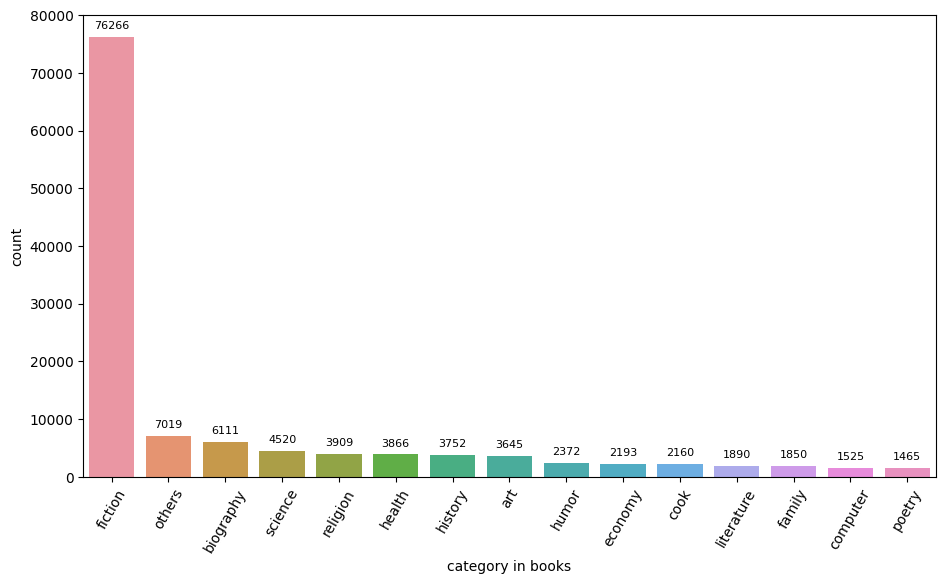

In [61]:
fig, ax= plt.subplots(1,1, figsize=(11,6))
ax = ax
my_dict= books['high_category'].value_counts().to_dict() #책 데이터 범주 분포
count= pd.DataFrame(list(my_dict.items()),columns = ['category in books','count'])
f = count.sort_values(by=['count'], ascending = False)
f = f.head(15) #많은 국가 15개만
sns.barplot(y = 'count',x= 'category in books' , data = f, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=60,horizontalalignment='center')
for bar in ax.patches: 
    ax.annotate(format(bar.get_height(), '.0f'),  
                   (bar.get_x() + bar.get_width() / 2,  
                    bar.get_height()), ha='center', va='center', 
                   size=8, xytext=(0,8), 
                   textcoords='offset points') 

plt.show()

이후 출판사 정제하기. 스페셜 미션에 있는 내용을 그대로 따라한 후, 상위권 출판사들을 일일히 k동건 클러스터링 함. 어마무시한 귀차니즘으로 인해 코드를 반복적으로 재사용하는 과정을 거쳐 남겨진 코드가 없음.

이미지

139212


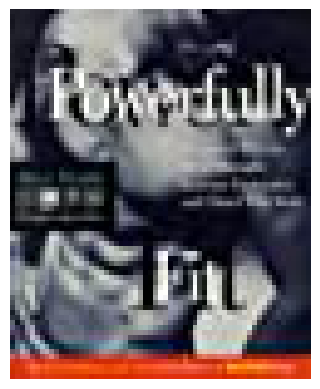

In [39]:
fig= plt.plot(figsize=(3,4))
rd = np.random.randint(0, len(books))
print(rd)
url = books['img_url'][rd]
img = np.asarray(Image.open(requests.get(url, stream=True).raw))
plt.axis("off")
plt.imshow(img)
#없는 이미지가 있는 듯하다. 몇몇 개는 그냥 보라화면
#이건 url을 활용해서 이미지를 띄우는 방식이다.

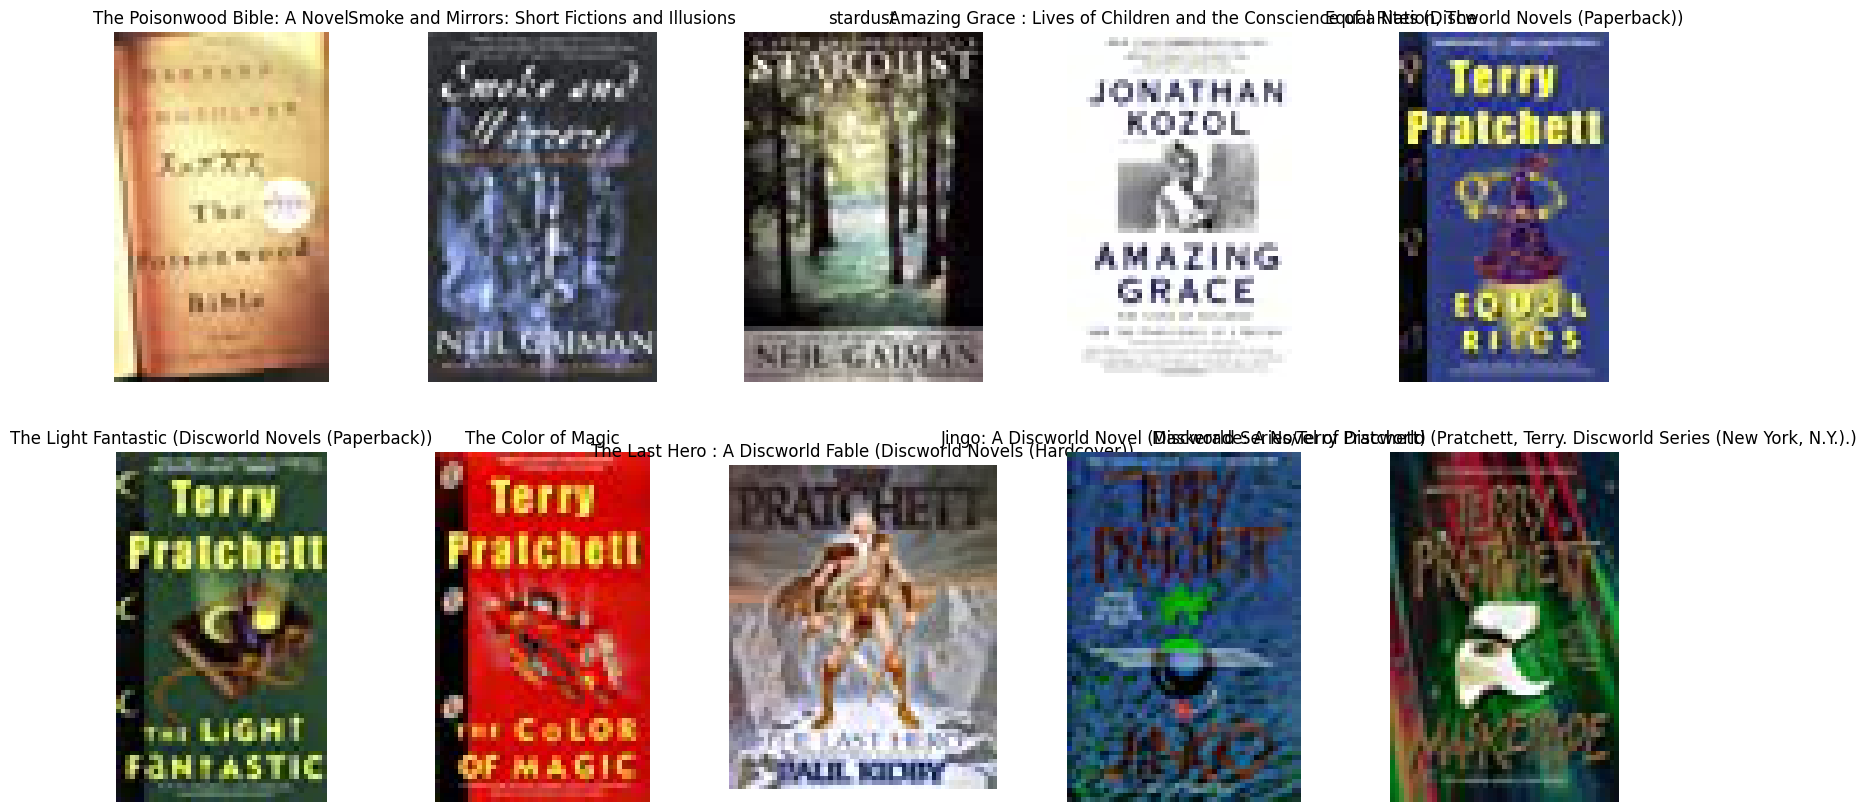

In [40]:
fig, ax = plt.subplots(2, 5, figsize=(20, 10)) 
image_path = './data/'
for i, ax in zip(range(280, 290), ax.flatten()):
    file_path = image_path+books['img_path'][i]
    img = np.asarray(Image.open(file_path))
    ax.imshow(img)
    ax.axis("off")
 
    ax.set_title(books['book_title'][i])

fig.show()


10793
File Size: 43 bytes
File Size: 1760 bytes


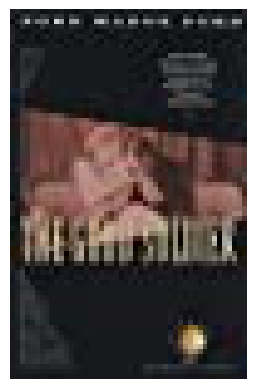

In [41]:
fig= plt.plot(figsize=(3,4))
rd = np.random.randint(0, len(books))
print(rd)
file_path = image_path+books['img_path'][rd]
img = np.asarray(Image.open(file_path))
plt.axis("off")
plt.imshow(img)
# print(image_path+books['img_path'][136803])
file_size = os.path.getsize('./data/images/0380708698.01.THUMBZZZ.jpg') 
print('File Size:', file_size, 'bytes') # 없는 이미지
file_size = os.path.getsize('./data/images/0310232716.01.THUMBZZZ.jpg') 
print('File Size:', file_size, 'bytes') # 있는 이미지

In [42]:
file_list = os.listdir("./data/images/")
rm_list = []
for i in file_list:
    file_size = os.path.getsize('./data/images/'+i)
    if file_size < 500: 
        rm_list.append('./data/images/'+i)
print(len(rm_list))
#실제로는 이미지가 없는 이미지 갯수

41896


In [100]:
isbn_lst = [i.split('/')[3].split('.')[0] for i in rm_list]

0394749650
http://images.amazon.com/images/P/0394749650.01.THUMBZZZ.jpg


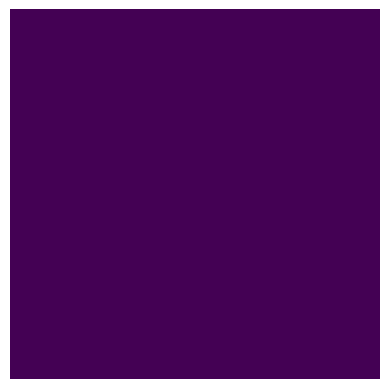

In [102]:
fig= plt.plot(figsize=(3,4))
rd = np.random.choice(isbn_lst)
url = books[books['isbn']== rd]['img_url'].values[0]
print(rd)
print(url)
img = np.asarray(Image.open(requests.get(url, stream=True).raw))
plt.axis("off")
plt.imshow(img)
# 만약 파일 경로 상 이미지가 없다면 url로도 없다는 것을 확인할 수 있다.(50번 무작위 확인)

# 학습 데이터

In [167]:
users= pd.read_csv(path+'users.csv')
train= pd.read_csv(path+'train_ratings.csv')
test = pd.read_csv(path+'test_ratings.csv')
train = train.merge(users).merge(books)
test = test.merge(users).merge(books)

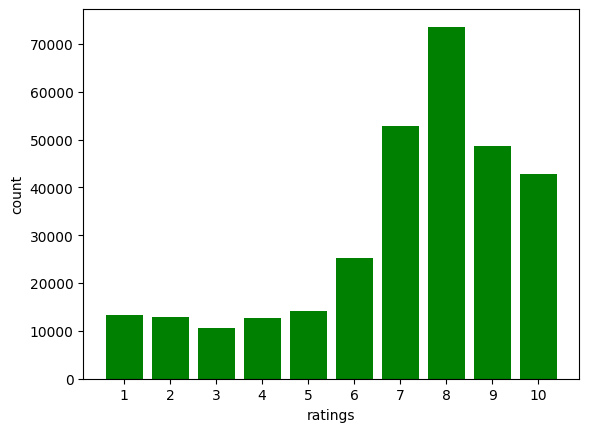

In [168]:
fig, ax = plt.subplots(1,1)

tmp = train['rating'].value_counts().sort_index()
ax.bar(tmp.index, tmp.values, color='green')
ax.set_xticks(tmp.index)
ax.set_xlabel('ratings')
ax.set_ylabel('count')

plt.show()
#8점을 준 사람이 굉장히 많다. 
#전반적으로 낮은 평점을 준 사람이 적은데, 이 사람들의 값을 이상치로 간주하고 생각을 해볼 수도 있다.
#물론 한 사람이 다채롭게 평점을 줄 수 있으니 그러한 점도 고려해야 한다. 

수상할 정도로 책을 많이 읽은 다독자들

In [169]:
print(train['user_id'].value_counts().iloc[:10].to_dict())
train['user_id'].value_counts().iloc[:10].sum()/len(train) # 전체에서 다독자 비율
#수상할 정도로 책을 많이 읽은 사람들이 있다. 이 사람들은 뭔가 이상하다.
#이 사람들의 평점을 알아보자

{11676: 5520, 98391: 4560, 189835: 1503, 153662: 1496, 23902: 956, 235105: 812, 76499: 810, 171118: 771, 16795: 760, 248718: 747}


0.05845923173454587

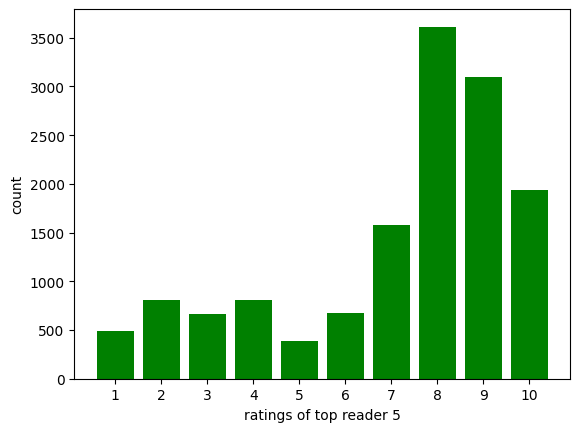

In [170]:
fig, ax = plt.subplots(1,1)

top_n = 5
tmp = train['user_id'].value_counts().iloc[:top_n].to_dict()
tmp = train[train['user_id'].isin(tmp.keys())]['rating'].value_counts().sort_index()
ax.bar(tmp.index, tmp.values, color='green')


ax.set_xticks(tmp.index)
ax.set_xlabel(f'ratings of top reader {top_n}')
ax.set_ylabel('count')

plt.show()
#상위 5명이 주는 평점. 겉으로 봤을 때는, 전체적인 그림과 조금 다르다
#그러나 5퍼센트 정도에 해당하는 값이며 어마무시하게 차이가 나는 것도 아니기에, 
#모델이 알아서 학습하도록 내버려두는 것도 괜찮을 것 같다.


In [171]:
#혹시 모르니 평균으로도 확인해보자. 

print(train['rating'].describe()[:3])

top_n = 10
tmp = train['user_id'].value_counts().index[:top_n]
tmp = train[train['user_id'].isin(tmp)]['rating']
print(tmp.describe()[:3])
#역시나 유의미한 특이점은 관찰되지 않는 것 같다.

count    306795.000000
mean          7.069714
std           2.433217
Name: rating, dtype: float64
count    17935.000000
mean         7.211319
std          2.494838
Name: rating, dtype: float64


콜드 스타트에 대한 고찰

In [172]:
print('유저 데이터에 없는 학습, 테스트 데이터 유저가 있는지')
print(len(set(test['user_id']) - set(users['user_id'])))
print(len(set(train['user_id']) - set(users['user_id'])))
#모든 데이터 속 유저는 유저셋에 들어있다.

print('평점 없는 아무개들')
print(len(set(users['user_id']) - set(train['user_id']))) 
#평점 없는 아무개들. 이들의 정보가 필요한가?
# 이들의 결측률도 봐야겠다.

#일단 콜드 스타트부터 파악하는 과정이 필요하다.
print('평점 정보가 없는 테스트 유저 수')
print(len(set(test['user_id']) - set(train['user_id'])))

#이 두 정보의 차이는? 평점이 없지만 테스트셋에 포함되지 않은 소수.
#이런 유저에 대해서 이웃 유저를 찾아주기에는 주어진 속성이 너무 적다. 
#해당 책에 내려진 평점을 토대로 추측



print('책 데이터에 없는 학습, 테스트 데이터 책이 있는지')
print(len(set(train['isbn']) - set(books['isbn'])))
print(len(set(test['isbn']) - set(books['isbn'])))

print('평점 없는 책')
print(len(set(books['isbn']) - set(train['isbn'])))

print('평점 없는 테스트 책 수')
print(len(set(test['isbn']) - set(train['isbn'])))
# 이번에는 차이가 없다. 정보가 없는 책들은 전부 테스트셋에 들어갔다는 뜻이다.
# 빌려진 적 없는 책들이라 치자. 이 책들에 대한 선호도는? 책의 이웃은 찾을 수 있을 것 같다.

#먼저 정보가 없는 유저라면? 그 책에 내려지는 전반적인 평점으로
#만약 정보가 없는 책을 빌린다면? 그 유저가 내리는 전반적인 평점으로

#콜드 스타트 유저와 책을 해결해야 하지만, 한편으로 다독자와 아닌 사람도 구분해야 한다.
#RMSE는 이상치에 민감하기 때문에 이상치를 낼 만한 사람들을 걸러주는 것이 관건이 될 것 같다.
#제공된 모델들은 이를 어떻게 처리하고 있는 것일까? 이미 잘 하고 있는 것인가?
#일단 딥러닝 모델은 단순하게 평점만을 가지고 학습을 진행한다.
# 학습셋 안에도 콜드 스타트는 존재하니, 이에 대해 어떤 연산이 이뤄지고 있을 것이다.

유저 데이터에 없는 학습, 테스트 데이터 유저가 있는지
0
0
평점 없는 아무개들
8289
평점 정보가 없는 테스트 유저 수
8266
책 데이터에 없는 학습, 테스트 데이터 책이 있는지
0
0
평점 없는 책
19793
평점 없는 테스트 책 수
19793


In [179]:
tmp = train['user_id'].unique()
no_exist = test[test['user_id'].isin(tmp) == False]
print('평점 없는 유저가 내릴 평점 갯수')
print(len(no_exist['user_id']))
print('평점 없는 유저 수')
print(len(set(no_exist['user_id'])))

평점 없는 유저가 내릴 평점 갯수
8677
평점 없는 유저 수
8266


,user_id,isbn,rating,location,age,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path,category_high,high_category
7,36197,0452264464,0,"topeka, kansas, usa",44.0,Beloved (Plume Contemporary Fiction),Toni Morrison,1994.0,Plume Books,http://images.amazon.com/images/P/0452264464.0...,en,fiction,Staring unflinchingly into the abyss of slaver...,images/0452264464.01.THUMBZZZ.jpg,fiction,fiction
11,144803,0452264464,0,"little rock, arkansas, usa",23.0,Beloved (Plume Contemporary Fiction),Toni Morrison,1994.0,Plume Books,http://images.amazon.com/images/P/0452264464.0...,en,fiction,Staring unflinchingly into the abyss of slaver...,images/0452264464.01.THUMBZZZ.jpg,fiction,fiction
28,94542,0449005615,0,"oregon city, oregon, usa",30.0,Seabiscuit: An American Legend,LAURA HILLENBRAND,2002.0,Fawcett Books,http://images.amazon.com/images/P/0449005615.0...,en,history,True story of how three men and a great raceho...,images/0449005615.01.THUMBZZZ.jpg,history,history
31,125222,0449005615,0,"palo alto, california, usa",NaN,Seabiscuit: An American Legend,LAURA HILLENBRAND,2002.0,Fawcett Books,http://images.amazon.com/images/P/0449005615.0...,en,history,True story of how three men and a great raceho...,images/0449005615.01.THUMBZZZ.jpg,history,history
34,132686,0449005615,0,"beverly hills, california, usa",20.0,Seabiscuit: An American Legend,LAURA HILLENBRAND,2002.0,Fawcett Books,http://images.amazon.com/images/P/0449005615.0...,en,history,True story of how three men and a great raceho...,images/0449005615.01.THUMBZZZ.jpg,history,history
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76671,275579,270022793X,0,"marcq-en-baroeul, nord, france",47.0,Papy bat tous les records,Beatrice Rouer,2002.0,Rageot,http://images.amazon.com/images/P/270022793X.0...,fr,germany,Afin de faire de la publicité pour le magasin ...,images/270022793X.01.THUMBZZZ.jpg,germany,germany
76674,275828,0802138748,0,"arlington, massachusetts, usa",55.0,Woodcuts of Women: Stories,Dagoberto Gilb,2002.0,Grove Press,http://images.amazon.com/images/P/0802138748.0...,en,fiction,A collection of stories by the award-winning L...,images/0802138748.01.THUMBZZZ.jpg,fiction,fiction
76676,276067,0694004162,0,"reston, virginia, usa",36.0,If You Give a Mouse a Cookie/Mini Book and Mou...,Laura Joffe Numeroff,1992.0,HarperAudio,http://images.amazon.com/images/P/0694004162.0...,en,juvenile fiction,Relating the cycle of requests a mouse is like...,images/0694004162.01.THUMBZZZ.jpg,fiction,fiction
76690,277079,3499263998,0,"berlin, berlin, germany",NaN,Eine Zierde in ihrem Hause. Die Geschichte der...,Asta Scheib,2002.0,Rowohlt Tb.,http://images.amazon.com/images/P/3499263998.0...,NaN,1,NaN,images/3499263998.01.THUMBZZZ.jpg,NaN,fiction


In [174]:
no_exist = no_exist.merge(users).merge(books)
len(no_exist['user_id']) / len(test)
#11퍼에 해당하는 테스트 데이터 속 유저가 콜드 스타트이다.
#책에서도 콜드 스타트가 있을 텐데, 이까지 확인은 못 함.

0.11313054929008201

<BarContainer object of 91 artists>

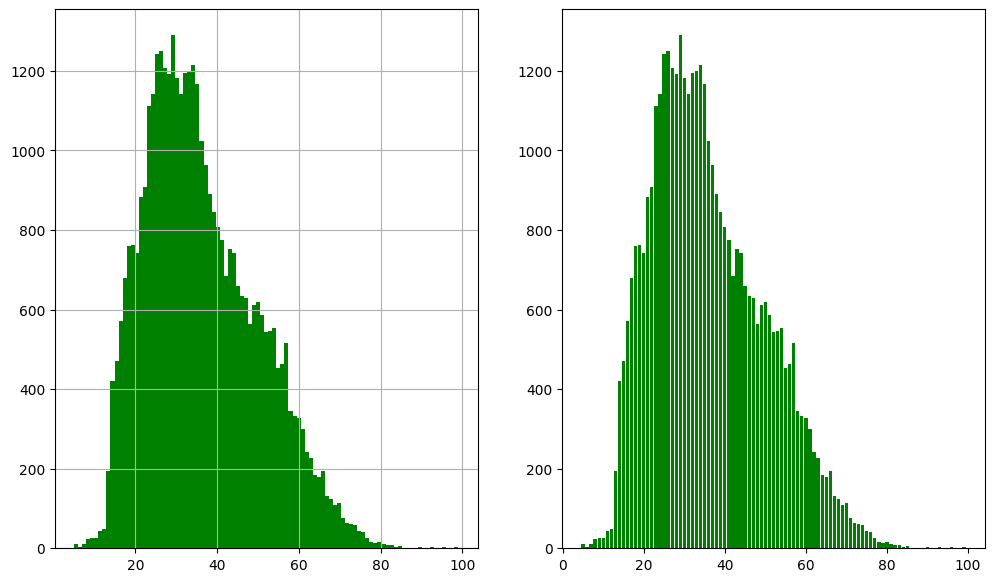

In [175]:
#전체 유저 나이대.
fig, ax = plt.subplots(1,2, figsize=(12, 7))
ax = ax.flatten()

users['age'].hist(bins=95, color='green', ax=ax[0])

cold_age = users['age'].value_counts().to_dict()
ax[1].bar(cold_age.keys(), cold_age.values(), color='green')
#둘은 같은 그래프. 그냥 어떤 식으로 다른 함수인지 찍어봤다.


<BarContainer object of 76 artists>

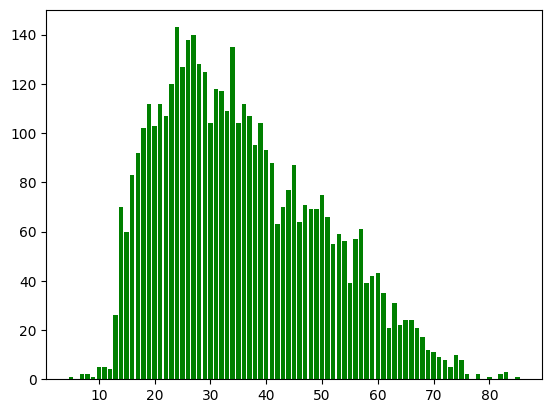

In [176]:
#일단 특정 나이대나 확인해보자
fig, ax = plt.subplots(1,1)
cold_age = users[users['user_id'].isin(no_exist['user_id'])]['age'].value_counts().to_dict()
ax.bar(cold_age.keys(), cold_age.values(), color='green')

In [180]:
print(no_exist['age'].isna().sum())
no_exist['age'].isna().sum() / len(no_exist)
#콜유의 나이 결측치. 조금 높다.

3899


0.4493488532903077

In [181]:
#지역 관련 전처리된 파일
users = pd.read_csv('/opt/ml/input/code/users_fillna.csv')

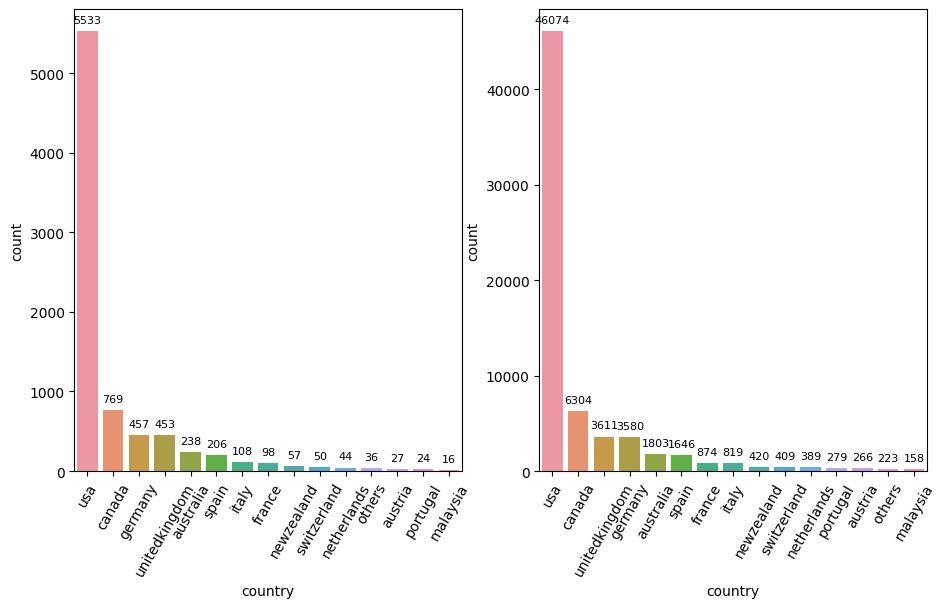

In [182]:
fig, ax= plt.subplots(1,2, figsize=(11,6))
ax = ax
my_dict=(users[users['user_id'].isin(no_exist['user_id'])]['country'].value_counts()).to_dict() 
# 국가별 콜유
count= pd.DataFrame(list(my_dict.items()),columns = ['country','count'])
f = count.sort_values(by=['count'], ascending = False)
f = f.head(15) #많은 국가 15개만
sns.barplot(y = 'count',x= 'country' , data = f, ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=60,horizontalalignment='center')
for bar in ax[0].patches: 
    ax[0].annotate(format(bar.get_height(), '.0f'),  
                   (bar.get_x() + bar.get_width() / 2,  
                    bar.get_height()), ha='center', va='center', 
                   size=8, xytext=(0,8), 
                   textcoords='offset points') 

my_dict=(users['country'].value_counts()).to_dict() 
#국가별 평점자
count= pd.DataFrame(list(my_dict.items()),columns = ['country','count'])
f = count.sort_values(by=['count'], ascending = False)
f = f.head(15) #많은 국가 15개만
sns.barplot(y = 'count',x= 'country' , data = f, ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=60,horizontalalignment='center')
for bar in ax[1].patches: 
    ax[1].annotate(format(bar.get_height(), '.0f'),  
                   (bar.get_x() + bar.get_width() / 2,  
                    bar.get_height()), ha='center', va='center', 
                   size=8, xytext=(0,8), 
                   textcoords='offset points') 

plt.show()

In [183]:
# 진행 순서가 많이 꼬여있어 재정비
train= pd.read_csv(path+'train_ratings.csv')
train = train.merge(users).merge(books)
test = test.merge(users).merge(books)
tmp = train['user_id'].unique()
no_exist = test[test['user_id'].isin(tmp) == False]

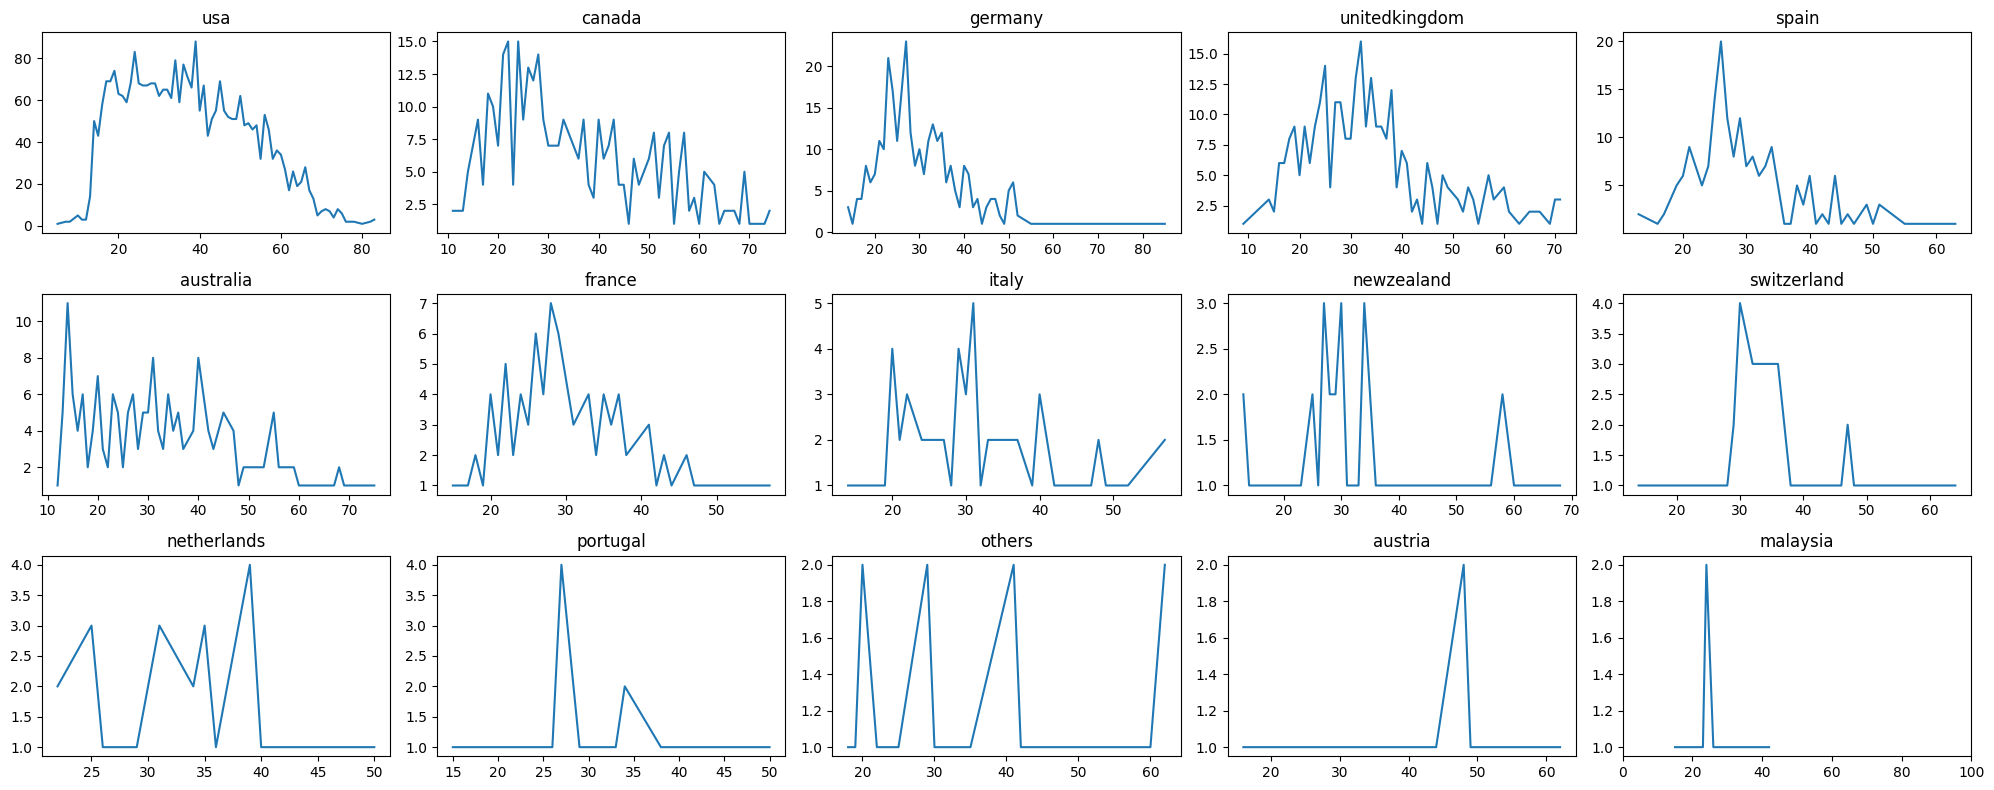

In [184]:
fig, ax = plt.subplots(3,5,figsize=(20,8))
#인구수 많은 상위 15개국 속 콜유들의 나이대

my_dict=(users[users['user_id'].isin(no_exist['user_id'])]['country'].value_counts()).to_dict() # 국가별 콜유
count= pd.DataFrame(list(my_dict.items()),columns = ['country','count'])
f = count.sort_values(by=['count'], ascending = False)
f = f.head(15)
for country, ax_ in zip(f['country'], ax.flatten()):
    no_exist[no_exist['country'] == country]['age'].value_counts().sort_index().plot(ax=ax_, title=country)
plt.xlim(0,100)
plt.tight_layout()
plt.show()

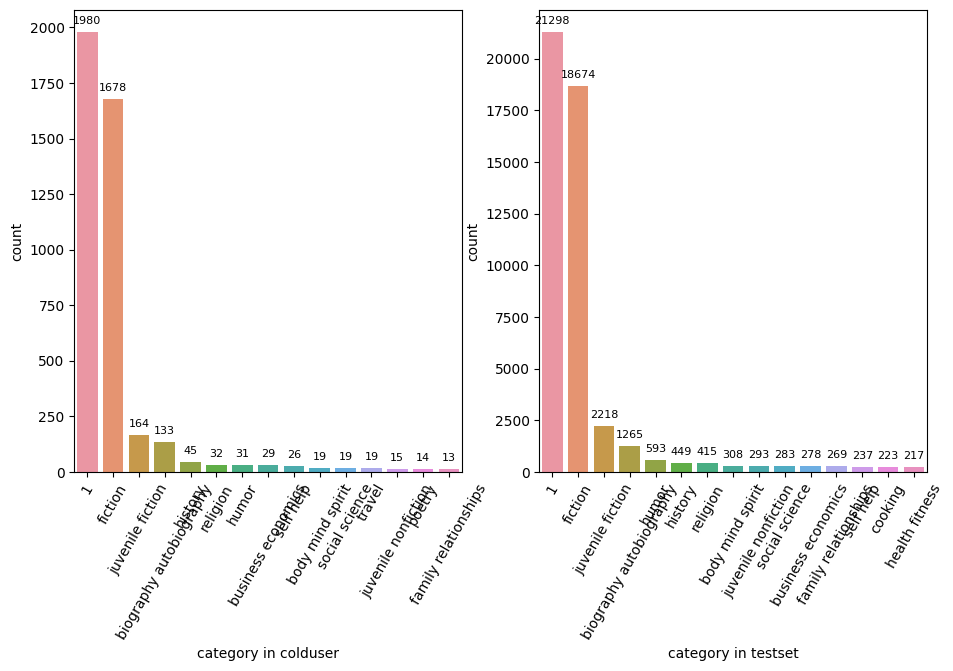

In [185]:
fig, ax= plt.subplots(1,2, figsize=(11,6))
ax = ax
my_dict= no_exist['category'].value_counts().to_dict() #콜유 내의 범주 분포
count= pd.DataFrame(list(my_dict.items()),columns = ['category in colduser','count'])
f = count.sort_values(by=['count'], ascending = False)
f = f.head(15) #많은 국가 15개만
sns.barplot(y = 'count',x= 'category in colduser' , data = f, ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=60,horizontalalignment='center')
for bar in ax[0].patches: 
    ax[0].annotate(format(bar.get_height(), '.0f'),  
                   (bar.get_x() + bar.get_width() / 2,  
                    bar.get_height()), ha='center', va='center', 
                   size=8, xytext=(0,8), 
                   textcoords='offset points') 

tmp = test.merge(books)
my_dict= tmp['category'].value_counts().to_dict() #학습셋 내 범주 분포
count= pd.DataFrame(list(my_dict.items()),columns = ['category in testset','count'])
f = count.sort_values(by=['count'], ascending = False)
f = f.head(15) #많은 국가 15개만
sns.barplot(y = 'count',x= 'category in testset' , data = f, ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=60,horizontalalignment='center')
for bar in ax[1].patches: 
    ax[1].annotate(format(bar.get_height(), '.0f'),  
                   (bar.get_x() + bar.get_width() / 2,  
                    bar.get_height()), ha='center', va='center', 
                   size=8, xytext=(0,8), 
                   textcoords='offset points') 

plt.show()

In [186]:
print('콜유 내의 카테고리 결측률')
print(len(no_exist[no_exist['category']=='1']) ,len(no_exist[no_exist['category']=='1']) / len(no_exist))


콜유 내의 카테고리 결측률
1980 0.4143993302637087


잠시 간단하게나마 분포 확인

In [193]:
train_category = train['category'].value_counts().to_dict()

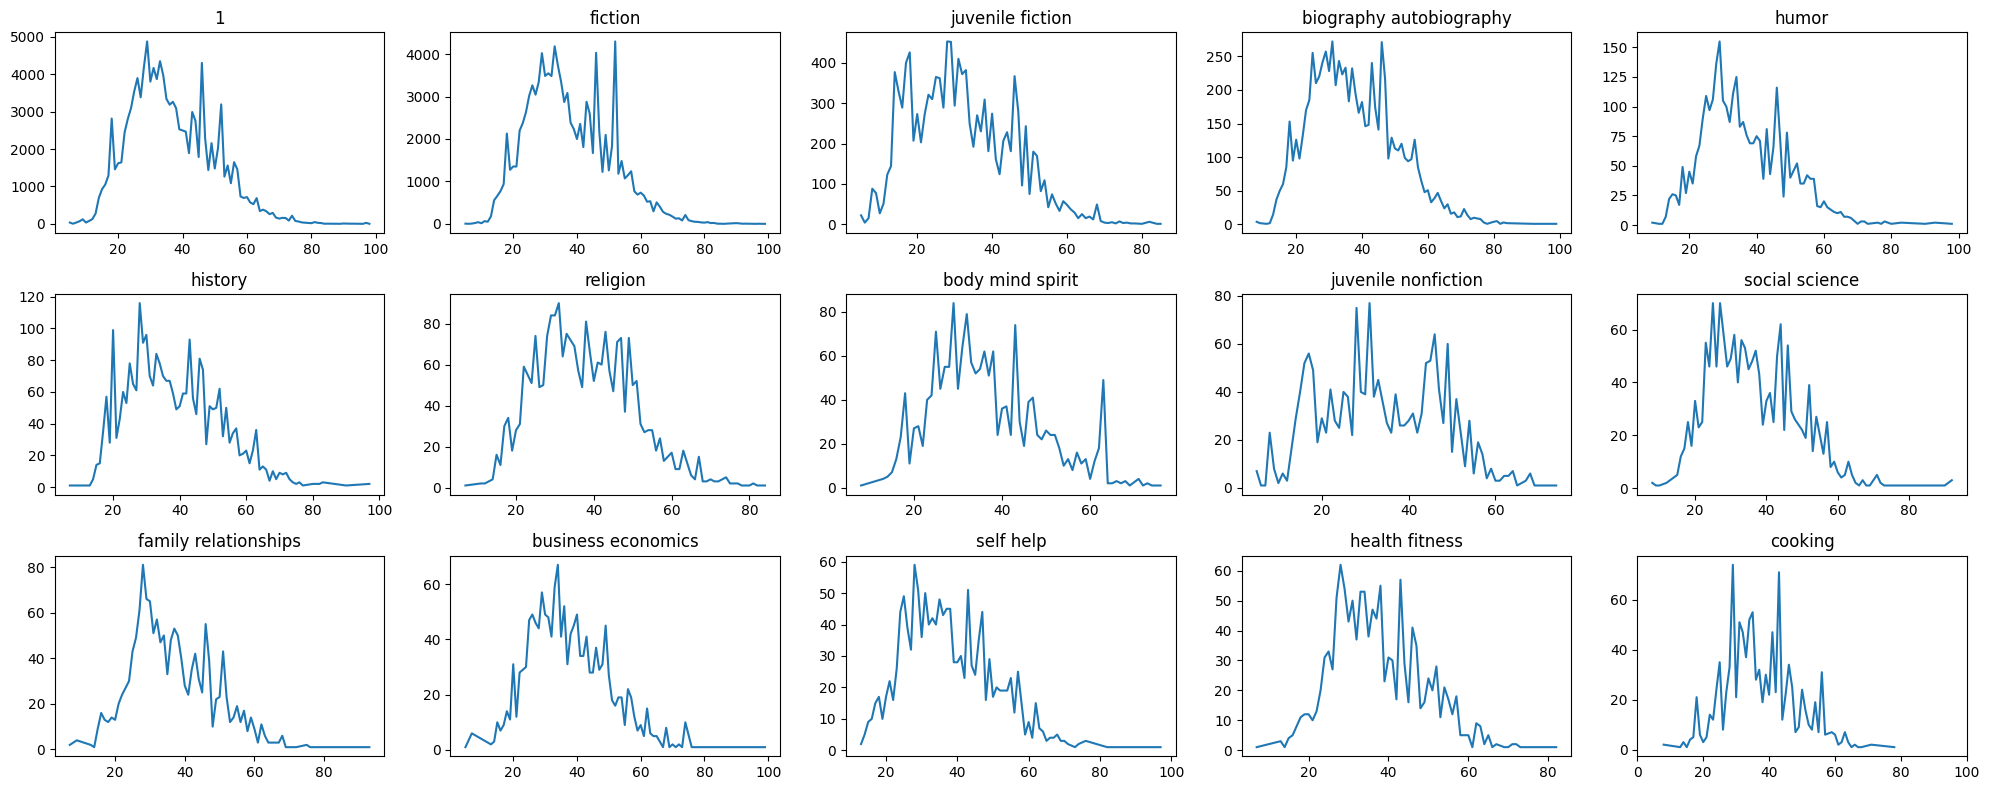

In [192]:
#학습셋 내의 상위 범주에서의 나이 분포.
fig, ax = plt.subplots(3,5,figsize=(20,8))

my_dict=train_category
count= pd.DataFrame(list(my_dict.items()),columns = ['country','count'])
f = count.sort_values(by=['count'], ascending = False)
f = f.head(15)
for country, ax_ in zip(f['country'], ax.flatten()):
    train[train['category'] == country]['age'].value_counts().sort_index().plot(ax=ax_, title=country)
plt.xlim(0,100)
plt.tight_layout()
plt.show()

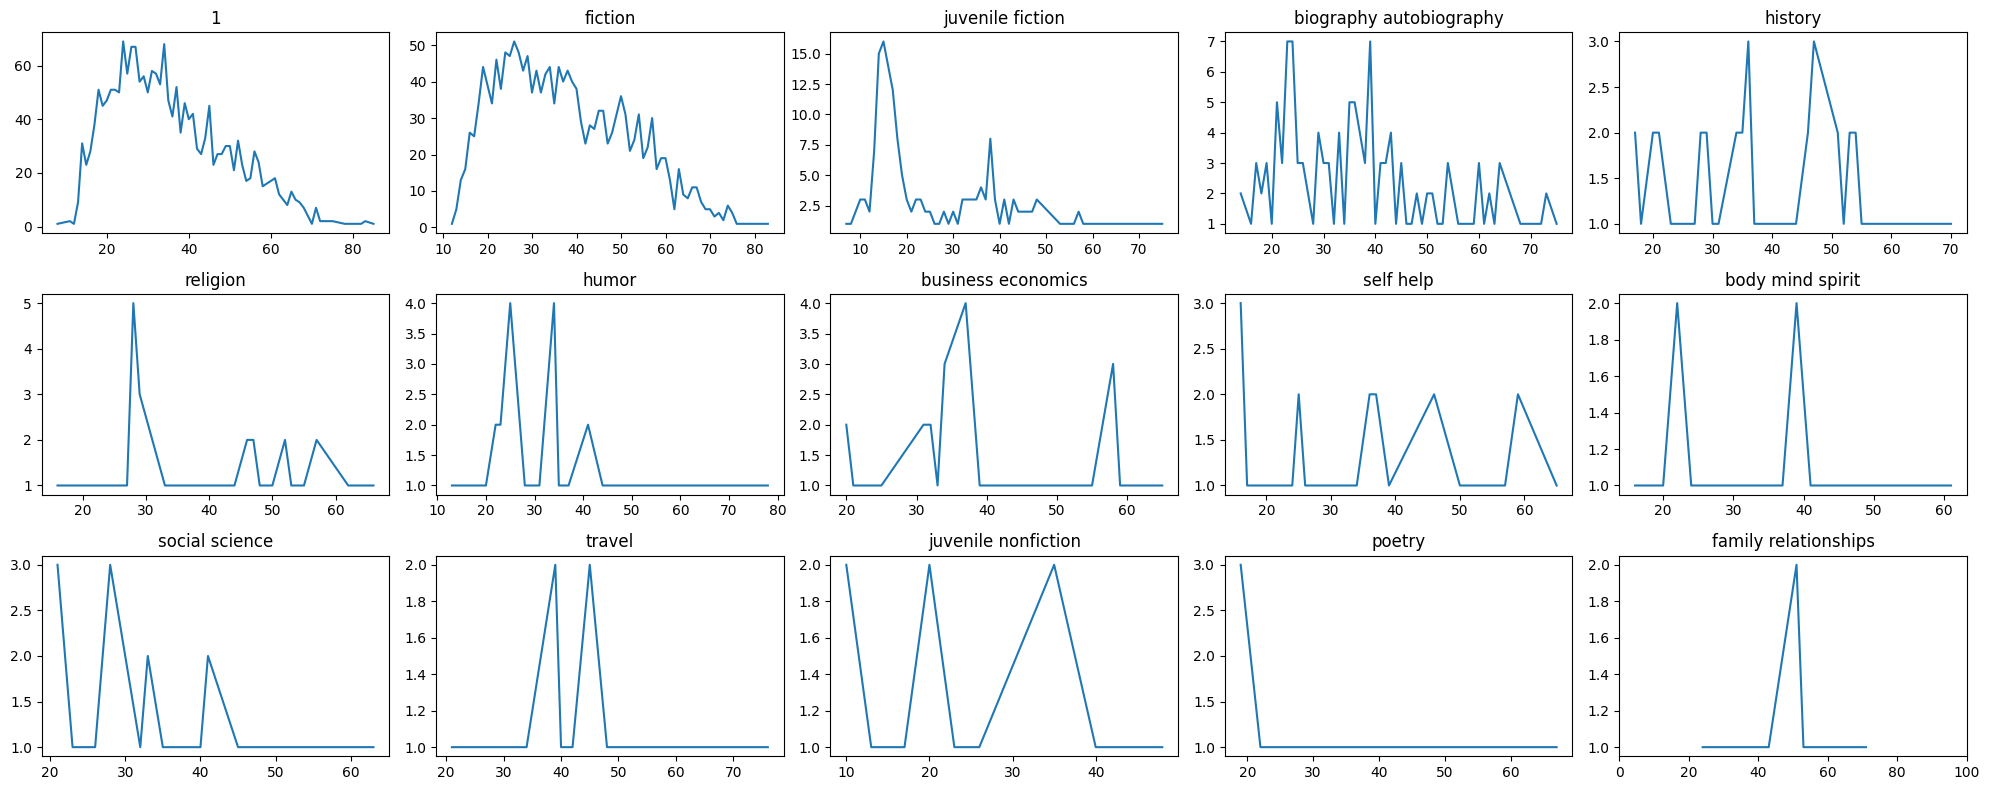

In [194]:
#콜유 내의 상위 범주에서의 나이 분포.
fig, ax = plt.subplots(3,5,figsize=(20,8))

my_dict=no_exist['category'].value_counts().to_dict()
count= pd.DataFrame(list(my_dict.items()),columns = ['country','count'])
f = count.sort_values(by=['count'], ascending = False)
f = f.head(15)
for country, ax_ in zip(f['country'], ax.flatten()):
    no_exist[no_exist['category'] == country]['age'].value_counts().sort_index().plot(ax=ax_, title=country)
plt.xlim(0,100)
plt.tight_layout()
plt.show()

콜유(콜드 스타트 유저)에 대해 나름의 대응을 하기 위해 분석을 해보았으나 시간과 실력의 한계로 유의미한 대응책을 마련해내지 못함.